# **// GROOVE GURU //**
#### *(An Audio Analysis, Music Mixing and Production Assistant Tool)*


# Workflow Diagram

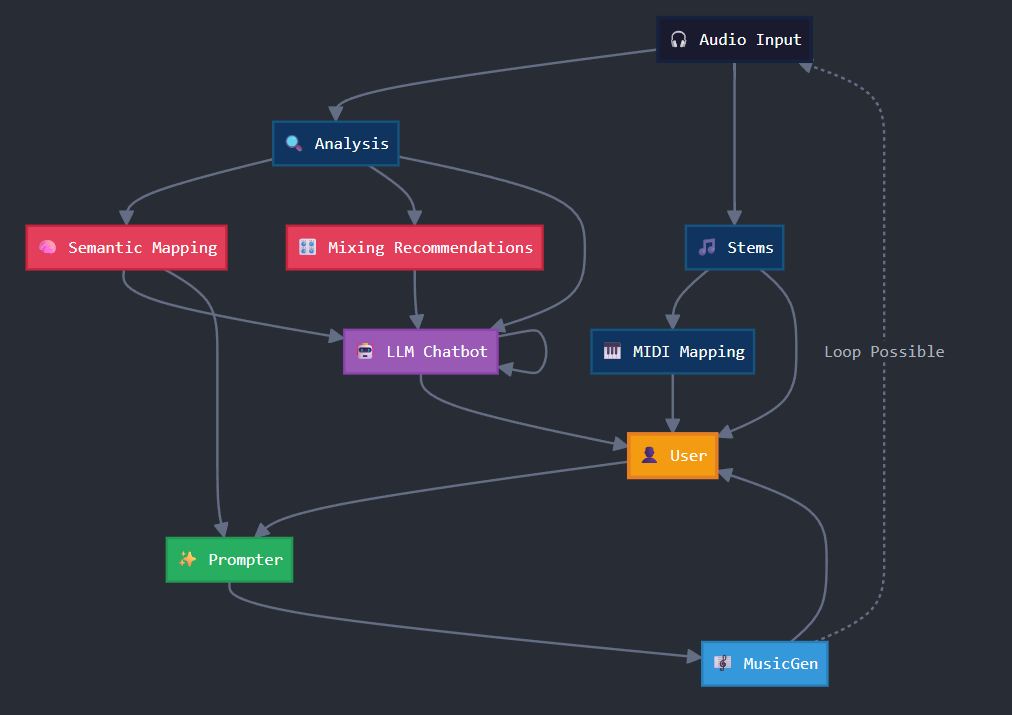

# Libraries

In [ ]:
!pip install -r ../requirements.txt

# Complete APP Workflow

## Audio_Features_Analisys

In [ ]:
"""
Audio Analysis Module
====================
Extracts comprehensive audio features for mixing recommendation system.
Compatible with the mixing recommendation mapper.
"""

import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
from typing import Dict, Any, Tuple, Optional
import warnings

# Suppress librosa warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

def analyze_audio_features(audio_data: np.ndarray, sample_rate: int) -> Dict[str, Any]:
    """
    Comprehensive audio analysis function that extracts all features needed
    for mixing recommendations.

    Args:
        audio_data: Audio signal as numpy array
        sample_rate: Sample rate of the audio

    Returns:
        Dictionary containing all extracted audio features
    """
    # Ensure mono audio for most analyses
    if audio_data.ndim > 1:
        audio_mono = np.mean(audio_data, axis=0)  # Convert to mono
        audio_stereo = audio_data
    else:
        audio_mono = audio_data
        audio_stereo = None

    # Initialize results dictionary
    features = {}

    # === CORE MUSICAL FEATURES ===
    try:
        # Key and tempo analysis
        key_info = _analyze_key_and_tonality(audio_mono, sample_rate)
        tempo_info = _analyze_tempo_and_rhythm(audio_mono, sample_rate)

        features.update(key_info)
        features.update(tempo_info)

        # === SPECTRAL AND TIMBRAL FEATURES ===
        spectral_features = _analyze_spectral_features(audio_mono, sample_rate)
        features.update(spectral_features)

        # === DYNAMIC AND LOUDNESS FEATURES ===
        dynamic_features = _analyze_dynamic_features(audio_mono, sample_rate)
        features.update(dynamic_features)

        # === HARMONIC AND PERCUSSIVE FEATURES ===
        harmonic_features = _analyze_harmonic_features(audio_mono, sample_rate)
        features.update(harmonic_features)

        # === SPATIAL FEATURES (if stereo) ===
        if audio_stereo is not None:
            spatial_features = _analyze_spatial_features(audio_stereo, sample_rate)
            features.update(spatial_features)
        else:
            # Default stereo width for mono files
            features['stereo_width'] = 0.0

        # === DERIVED FEATURES FOR MIXING ===
        derived_features = _calculate_derived_features(features, audio_mono, sample_rate)
        features.update(derived_features)

        # Add basic metadata
        features['duration'] = len(audio_mono) / sample_rate
        features['sample_rate'] = sample_rate
        features['is_stereo'] = audio_stereo is not None

    except Exception as e:
        # Fallback with basic features if analysis fails
        print(f"Warning: Audio analysis failed with error: {e}")
        features = _get_fallback_features(audio_mono, sample_rate)

    return features

def _analyze_key_and_tonality(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Analyze musical key and tonal features."""
    # Extract chroma features
    chroma = lb.feature.chroma_cqt(y=audio, sr=sr)

    # Apply recency weighting (more weight to recent notes)
    weights = np.linspace(0.5, 1.5, chroma.shape[1])
    chroma_weighted = chroma * weights
    chroma_norm = chroma_weighted / (chroma_weighted.sum(axis=0, keepdims=True) + 1e-8)

    # Krumhansl-Schmuckler key profiles
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

    scores = []

    # Test all 24 possible keys (12 major + 12 minor)
    for i in range(12):
        rotated_major = np.roll(major_profile, i)
        rotated_minor = np.roll(minor_profile, i)

        # Calculate correlation scores
        score_major = np.sum(chroma_norm.mean(axis=1) * rotated_major)
        score_minor = np.sum(chroma_norm.mean(axis=1) * rotated_minor)

        scores.append((score_major, 'Major', i))
        scores.append((score_minor, 'Minor', i))

    # Find best match
    best_score, mode, tonic = max(scores, key=lambda x: x[0])

    # Key names
    key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Hierarchical analysis (tonic triad strength)
    triad = [tonic, (tonic + 4) % 12, (tonic + 7) % 12]  # Major triad intervals
    triad_strength = np.sum(chroma_norm[triad, :].mean(axis=1))

    # Tonal stability analysis
    tonic_series = np.argmax(chroma, axis=0)
    tonic_stability = np.sum(np.diff(tonic_series) == 0) / (len(tonic_series) - 1 + 1e-8)

    return {
        'key': f"{key_names[tonic]} {mode}",
        'key_confidence': best_score,
        'tonic_stability': tonic_stability,
        'triad_strength': triad_strength
    }

def _analyze_tempo_and_rhythm(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Analyze tempo and rhythmic characteristics."""
    # Onset detection and tempo estimation
    onset_env = lb.onset.onset_strength(y=audio, sr=sr)
    tempo_global, beats = lb.beat.beat_track(onset_envelope=onset_env, sr=sr)

    # Analyze tempo stability using windowed analysis
    hop_length = 512
    frame_length = 2048
    tempo_segments = []

    # Windowed tempo analysis
    for start in range(0, len(onset_env) - frame_length, hop_length):
        segment = onset_env[start:start + frame_length]
        if len(segment) >= frame_length:
            tempo_segment, _ = lb.beat.beat_track(onset_envelope=segment, sr=sr)
            tempo_segments.append(tempo_segment)

    if tempo_segments:
        tempo_median = np.median(tempo_segments)
        tempo_std = np.std(tempo_segments)
        tempo_stability = 1 - (tempo_std / (tempo_median + 1e-8))
    else:
        tempo_median = tempo_global
        tempo_stability = 1.0

    # Onset analysis
    onsets = lb.onset.onset_detect(y=audio, sr=sr, units='time')
    onset_rate = len(onsets) / (len(audio) / sr) if len(audio) > 0 else 0

    # Rhythmic regularity
    if len(onsets) > 2:
        onset_intervals = np.diff(onsets)
        rhythmic_regularity = 1 - (np.std(onset_intervals) / (np.mean(onset_intervals) + 1e-8))
        rhythmic_regularity = np.clip(rhythmic_regularity, 0, 1)
    else:
        rhythmic_regularity = 0.5

    return {
        'tempo': float(tempo_median),
        'tempo_confidence': float(tempo_stability),
        'onset_rate': float(onset_rate),
        'rhythmic_regularity': float(rhythmic_regularity)
    }

def _analyze_spectral_features(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Extract spectral and frequency-domain features."""
    # Basic spectral features
    spectral_centroid = lb.feature.spectral_centroid(y=audio, sr=sr)[0]
    spectral_rolloff = lb.feature.spectral_rolloff(y=audio, sr=sr)[0]
    spectral_contrast = lb.feature.spectral_contrast(y=audio, sr=sr)
    zero_crossing_rate = lb.feature.zero_crossing_rate(audio)[0]

    # MFCC features for timbral analysis
    mfccs = lb.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Frequency band energy analysis (compatible with mixing mapper)
    graves = np.mean(mfcc_mean[0:3])    # Low frequencies (bass)
    medios = np.mean(mfcc_mean[3:7])    # Mid frequencies
    agudos = np.mean(mfcc_mean[8:12])   # High frequencies (treble)

    # Timbral complexity
    complejidad_timbral = np.std(mfcc_mean[1:]) * 10  # Scale for compatibility

    return {
        'spectral_centroid': float(np.mean(spectral_centroid)),
        'spectral_rolloff': float(np.mean(spectral_rolloff)),
        'spectral_contrast_mean': float(np.mean(spectral_contrast)),
        'zero_crossing_rate': float(np.mean(zero_crossing_rate)),
        'mfcc_features': mfcc_mean.tolist(),
        'graves': float(graves),
        'medios': float(medios),
        'agudos': float(agudos),
        'graves_medios_agudos': [float(graves), float(medios), float(agudos)],
        'complejidad_timbral': float(complejidad_timbral)
    }

def _analyze_dynamic_features(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Analyze dynamic range and loudness characteristics."""
    # RMS energy and loudness
    rms = lb.feature.rms(y=audio)[0]
    loudness_mean = np.mean(rms)
    loudness_db = 20 * np.log10(loudness_mean + 1e-8)

    # Crest factor (peak-to-average ratio)
    peak_level = np.max(np.abs(audio))
    crest_factor = peak_level / (loudness_mean + 1e-8)

    # Dynamic range analysis
    percentile_95 = np.percentile(np.abs(audio), 95)
    percentile_10 = np.percentile(np.abs(audio), 10)
    dynamic_range = 20 * np.log10((percentile_95 + 1e-8) / (percentile_10 + 1e-8))

    return {
        'loudness_db': float(loudness_db),
        'rms_energy': float(loudness_mean),
        'crest_factor': float(crest_factor),
        'peak_level': float(peak_level),
        'dynamic_range': float(dynamic_range)
    }

def _analyze_harmonic_features(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Analyze harmonic and percussive content."""
    # Harmonic-percussive separation
    y_harmonic, y_percussive = lb.effects.hpss(audio)

    # Calculate harmonic ratio (approximation of instrumentalness)
    harmonic_energy = np.mean(np.abs(y_harmonic))
    total_energy = np.mean(np.abs(audio))
    harmonic_ratio = harmonic_energy / (total_energy + 1e-8)

    # Percussive ratio
    percussive_energy = np.mean(np.abs(y_percussive))
    percussive_ratio = percussive_energy / (total_energy + 1e-8)

    # Tonnetz features for harmonic complexity
    try:
        tonnetz = lb.feature.tonnetz(y=audio, sr=sr)
        harmonic_complexity = np.std(tonnetz)
    except:
        harmonic_complexity = 0.5

    return {
        'instrumentalness': float(harmonic_ratio),
        'harmonic_ratio': float(harmonic_ratio),
        'percussive_ratio': float(percussive_ratio),
        'harmonic_complexity': float(harmonic_complexity)
    }

def _analyze_spatial_features(audio_stereo: np.ndarray, sr: int) -> Dict[str, Any]:
    """Analyze stereo spatial characteristics."""
    if audio_stereo.shape[0] >= 2:
        left_channel = audio_stereo[0]
        right_channel = audio_stereo[1]

        # Stereo correlation
        correlation = np.corrcoef(left_channel, right_channel)[0, 1]
        stereo_width = 1 - abs(correlation)  # Higher values = wider stereo image
        stereo_width = np.clip(stereo_width, 0, 1)

        # Phase correlation (mono compatibility)
        phase_correlation = correlation

    else:
        stereo_width = 0.0
        phase_correlation = 1.0

    return {
        'stereo_width': float(stereo_width),
        'phase_correlation': float(phase_correlation)
    }

def _calculate_derived_features(features: Dict[str, Any], audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Calculate additional derived features for mixing recommendations."""
    # Arrangement density approximation
    spectral_flux = np.mean(np.diff(np.abs(lb.stft(audio)), axis=1) ** 2)
    arrangement_density = np.clip(spectral_flux / 1000, 0, 1)  # Normalized approximation

    # Punch factor (low-frequency contrast)
    if 'spectral_contrast_mean' in features:
        punch_factor = features['spectral_contrast_mean']
    else:
        punch_factor = 0.5

    # Sub-bass energy
    if 'graves' in features:
        sub_bass_energy = features['graves']
    else:
        sub_bass_energy = 0.0

    # Loopability score (auto-correlation based)
    try:
        autocorr = np.correlate(audio, audio, mode='full')
        mid = len(autocorr) // 2
        if mid + 3*sr < len(autocorr):
            loopability_score = np.max(autocorr[mid + sr//2 : mid + 3*sr]) / (np.max(autocorr) + 1e-8)
        else:
            loopability_score = 0.5
    except:
        loopability_score = 0.5

    return {
        'arrangement_density': float(arrangement_density),
        'punch_factor': float(punch_factor),
        'sub_bass_energy': float(sub_bass_energy),
        'loopability_score': float(loopability_score)
    }

def _get_fallback_features(audio: np.ndarray, sr: int) -> Dict[str, Any]:
    """Provide fallback features if analysis fails."""
    return {
        # Core features with safe defaults
        'key': 'C Major',
        'tempo': 120.0,
        'spectral_centroid': 2000.0,
        'loudness_db': -20.0,
        'onset_rate': 3.0,
        'rhythmic_regularity': 0.6,
        'complejidad_timbral': 8.0,
        'graves': -10.0,
        'medios': 0.0,
        'agudos': -5.0,
        'graves_medios_agudos': [-10.0, 0.0, -5.0],
        'stereo_width': 0.5,
        'crest_factor': 6.0,
        'instrumentalness': 0.5,
        'arrangement_density': 0.5,
        'harmonic_complexity': 0.5,
        'duration': len(audio) / sr,
        'sample_rate': sr,
        'is_stereo': False
    }

def extract_features_for_mixing(audio_data: np.ndarray, sample_rate: int) -> Dict[str, Any]:
    """
    Main entry point for feature extraction optimized for mixing recommendations.
    This function ensures compatibility with the mixing recommendation system.

    Args:
        audio_data: Audio signal as numpy array
        sample_rate: Sample rate of the audio

    Returns:
        Dictionary with features formatted for mixing recommendations
    """
    # Get full feature analysis
    features = analyze_audio_features(audio_data, sample_rate)

    # Ensure all required features for mixing recommendations are present
    required_features = [
        'tempo', 'loudness_db', 'spectral_centroid', 'instrumentalness',
        'onset_rate', 'rhythmic_regularity', 'complejidad_timbral',
        'graves_medios_agudos', 'stereo_width', 'crest_factor', 'arrangement_density'
    ]

    # Fill missing features with defaults
    for feature in required_features:
        if feature not in features:
            if feature == 'graves_medios_agudos':
                features[feature] = [features.get('graves', -10),
                                   features.get('medios', 0),
                                   features.get('agudos', -5)]
            elif feature == 'tempo':
                features[feature] = 120.0
            elif feature == 'loudness_db':
                features[feature] = -20.0
            elif feature == 'spectral_centroid':
                features[feature] = 2000.0
            else:
                features[feature] = 0.5  # Default normalized value

    return features

def get_audio_summary(features: Dict[str, Any]) -> Dict[str, Any]:
    """
    Generate a user-friendly summary of the audio characteristics.

    Args:
        features: Dictionary of extracted audio features

    Returns:
        Dictionary with interpretable audio characteristics
    """
    summary = {
        'musical_key': features.get('key', 'Unknown'),
        'tempo_bpm': round(features.get('tempo', 120), 1),
        'duration_seconds': round(features.get('duration', 0), 2),
        'overall_loudness_db': round(features.get('loudness_db', -20), 1),
        'brightness': 'Bright' if features.get('spectral_centroid', 2000) > 3000 else 'Warm',
        'rhythmic_activity': 'High' if features.get('onset_rate', 3) > 5 else 'Moderate' if features.get('onset_rate', 3) > 2 else 'Low',
        'stereo_image': 'Wide' if features.get('stereo_width', 0.5) > 0.7 else 'Narrow' if features.get('stereo_width', 0.5) < 0.3 else 'Moderate',
        'dynamic_range': 'High' if features.get('crest_factor', 6) > 10 else 'Compressed' if features.get('crest_factor', 6) < 4 else 'Moderate',
        'timbral_complexity': 'Complex' if features.get('complejidad_timbral', 8) > 12 else 'Simple' if features.get('complejidad_timbral', 8) < 6 else 'Moderate',
        'instrumental_content': 'Highly Instrumental' if features.get('instrumentalness', 0.5) > 0.8 else 'Mixed' if features.get('instrumentalness', 0.5) > 0.3 else 'Vocal-Heavy'
    }

    return summary


    def get_all_feature_names() -> list:
        """
        Returns a list of all feature names extracted by the audio analysis module.
        """
        return [
            'key',
            'key_confidence',
            'tonic_stability',
            'triad_strength',
            'tempo',
            'tempo_confidence',
            'onset_rate',
            'rhythmic_regularity',
            'spectral_centroid',
            'spectral_rolloff',
            'spectral_contrast_mean',
            'zero_crossing_rate',
            'mfcc_features',
            'graves',
            'medios',
            'agudos',
            'graves_medios_agudos',
            'complejidad_timbral',
            'loudness_db',
            'rms_energy',
            'crest_factor',
            'peak_level',
            'dynamic_range',
            'instrumentalness',
            'harmonic_ratio',
            'percussive_ratio',
            'harmonic_complexity',
            'stereo_width',
            'phase_correlation',
            'arrangement_density',
            'punch_factor',
            'sub_bass_energy',
            'loopability_score',
            'duration',
            'sample_rate',
            'is_stereo'
        ]

## Semantic_Mapping

In [ ]:
from typing import Dict, Any, List, Tuple, Callable
import numpy as np
from functools import lru_cache

# ====== CONFIGURATION AND NORMALIZATION RANGES ======

# Define feature normalization ranges for consistent semantic mapping
SEMANTIC_FEATURE_RANGES = {
    # Tonal Features
    'key_confidence': {'min': 0, 'max': 1, 'optimal': 0.8},
    'tonic_stability': {'min': 0, 'max': 1, 'optimal': 0.7},
    'triad_strength': {'min': 0, 'max': 1, 'optimal': 0.6},

    # Rhythmic Features
    'tempo': {'min': 60, 'max': 200, 'optimal_low': 80, 'optimal_high': 140},
    'tempo_confidence': {'min': 0, 'max': 1, 'optimal': 0.8},
    'onset_rate': {'min': 0, 'max': 10, 'optimal_low': 2, 'optimal_high': 6},
    'rhythmic_regularity': {'min': 0, 'max': 1, 'optimal': 0.7},

    # Spectral Features
    'spectral_centroid': {'min': 500, 'max': 8000, 'bright_threshold': 3500, 'dark_threshold': 1500},
    'spectral_rolloff': {'min': 2000, 'max': 16000, 'bright_threshold': 8000},
    'spectral_contrast_mean': {'min': 0, 'max': 30, 'high_threshold': 20},
    'zero_crossing_rate': {'min': 0, 'max': 1, 'percussive_threshold': 0.15},
    'graves': {'min': -40, 'max': 20, 'strong_threshold': -5, 'weak_threshold': -25},
    'medios': {'min': -30, 'max': 25, 'strong_threshold': 5, 'weak_threshold': -15},
    'agudos': {'min': -35, 'max': 15, 'strong_threshold': 0, 'weak_threshold': -20},
    'complejidad_timbral': {'min': 0, 'max': 25, 'complex_threshold': 15, 'simple_threshold': 5},

    # Dynamic Features
    'loudness_db': {'min': -60, 'max': 0, 'loud_threshold': -10, 'quiet_threshold': -35},
    'rms_energy': {'min': 0, 'max': 1, 'high_threshold': 0.3, 'low_threshold': 0.05},
    'crest_factor': {'min': 1, 'max': 25, 'dynamic_threshold': 10, 'compressed_threshold': 4},
    'dynamic_range': {'min': 0, 'max': 60, 'wide_threshold': 30, 'narrow_threshold': 10},

    # Structural Features
    'instrumentalness': {'min': 0, 'max': 1, 'instrumental_threshold': 0.7},
    'harmonic_ratio': {'min': 0, 'max': 1, 'harmonic_threshold': 0.6},
    'percussive_ratio': {'min': 0, 'max': 1, 'percussive_threshold': 0.4},
    'harmonic_complexity': {'min': 0, 'max': 15, 'complex_threshold': 8},
    'arrangement_density': {'min': 0, 'max': 1, 'dense_threshold': 0.7, 'sparse_threshold': 0.3},
    'punch_factor': {'min': 0, 'max': 1, 'punchy_threshold': 0.6},

    # Spatial Features
    'stereo_width': {'min': 0, 'max': 1, 'wide_threshold': 0.7, 'narrow_threshold': 0.3},
    'phase_correlation': {'min': -1, 'max': 1, 'good_threshold': 0.6}
}

'''
# Define key mappings for semantic interpretation
KEY_SEMANTIC_MAP = {
    'C': {'mood': 'stable', 'energy': 'neutral', 'character': 'foundational'},
    'C#': {'mood': 'mysterious', 'energy': 'medium', 'character': 'edgy'},
    'D': {'mood': 'bright', 'energy': 'high', 'character': 'triumphant'},
    'D#': {'mood': 'dramatic', 'energy': 'intense', 'character': 'bold'},
    'E': {'mood': 'confident', 'energy': 'high', 'character': 'assertive'},
    'F': {'mood': 'warm', 'energy': 'medium', 'character': 'pastoral'},
    'F#': {'mood': 'dreamy', 'energy': 'medium', 'character': 'ethereal'},
    'G': {'mood': 'uplifting', 'energy': 'high', 'character': 'joyful'},
    'G#': {'mood': 'tense', 'energy': 'high', 'character': 'aggressive'},
    'A': {'mood': 'balanced', 'energy': 'medium-high', 'character': 'natural'},
    'A#': {'mood': 'dark', 'energy': 'intense', 'character': 'ominous'},
    'B': {'mood': 'restless', 'energy': 'high', 'character': 'driving'}
}
'''
# Enhanced key semantic mapping with popular music terminology
KEY_SEMANTIC_MAP = {
    'C': {
        'mood': ['stable', 'grounded', 'foundational'],
        'energy': ['neutral', 'balanced', 'steady'],
        'character': ['classic', 'pure', 'natural'],
        'mixing_quality': ['clear', 'fundamental', 'reference']
    },
    'C#': {
        'mood': ['mysterious', 'edgy', 'tense'],
        'energy': ['medium', 'restless', 'charged'],
        'character': ['modern', 'urban', 'sophisticated'],
        'mixing_quality': ['sharp', 'cutting', 'distinctive']
    },
    'D': {
        'mood': ['bright', 'optimistic', 'celebratory'],
        'energy': ['high', 'uplifting', 'energetic'],
        'character': ['triumphant', 'joyful', 'bold'],
        'mixing_quality': ['brilliant', 'open', 'airy']
    },
    'D#': {
        'mood': ['dramatic', 'intense', 'passionate'],
        'energy': ['powerful', 'driving', 'forceful'],
        'character': ['bold', 'theatrical', 'commanding'],
        'mixing_quality': ['punchy', 'aggressive', 'impactful']
    },
    'E': {
        'mood': ['confident', 'assertive', 'strong'],
        'energy': ['high', 'dynamic', 'vibrant'],
        'character': ['heroic', 'determined', 'resilient'],
        'mixing_quality': ['strong', 'present', 'forward']
    },
    'F': {
        'mood': ['warm', 'gentle', 'peaceful'],
        'energy': ['medium', 'relaxed', 'flowing'],
        'character': ['pastoral', 'intimate', 'comfortable'],
        'mixing_quality': ['warm', 'rounded', 'smooth']
    },
    'F#': {
        'mood': ['dreamy', 'ethereal', 'floating'],
        'energy': ['medium', 'ambient', 'spacious'],
        'character': ['mystical', 'otherworldly', 'atmospheric'],
        'mixing_quality': ['spacious', 'dreamy', 'reverberant']
    },
    'G': {
        'mood': ['uplifting', 'joyful', 'positive'],
        'energy': ['high', 'bright', 'cheerful'],
        'character': ['happy', 'carefree', 'playful'],
        'mixing_quality': ['bright', 'sparkling', 'lively']
    },
    'G#': {
        'mood': ['tense', 'aggressive', 'dark'],
        'energy': ['intense', 'heavy', 'powerful'],
        'character': ['menacing', 'gothic', 'fierce'],
        'mixing_quality': ['heavy', 'dense', 'compressed']
    },
    'A': {
        'mood': ['balanced', 'natural', 'honest'],
        'energy': ['medium-high', 'stable', 'grounded'],
        'character': ['authentic', 'genuine', 'timeless'],
        'mixing_quality': ['natural', 'balanced', 'true']
    },
    'A#': {
        'mood': ['dark', 'brooding', 'mysterious'],
        'energy': ['intense', 'deep', 'heavy'],
        'character': ['ominous', 'serious', 'contemplative'],
        'mixing_quality': ['deep', 'rich', 'full']
    },
    'B': {
        'mood': ['restless', 'urgent', 'driving'],
        'energy': ['high', 'propulsive', 'unstable'],
        'character': ['anxious', 'pushing', 'relentless'],
        'mixing_quality': ['tight', 'focused', 'precise']
    }
}

# ====== MODULAR RULE-BASED STRUCTURES ======
'''
# Genre inference rules as modular structures
GENRE_INFERENCE_RULES = [
    {
        'genre': 'heavy_metal',
        'conditions': lambda f: (
            f.get('spectral_centroid', 2500) > 2500 and
            f.get('graves', -15) > -10 and
            f.get('complejidad_timbral', 8) > 12 and
            f.get('percussive_ratio', 0.3) > 0.4 and
            f.get('tempo', 120) > 140
        ),
        'confidence_factors': ['spectral_centroid', 'graves', 'complejidad_timbral', 'percussive_ratio', 'tempo']
    },
    {
        'genre': 'rock',
        'conditions': lambda f: (
            f.get('spectral_centroid', 2500) > 2500 and
            f.get('graves', -15) > -10 and
            f.get('complejidad_timbral', 8) > 12 and
            f.get('percussive_ratio', 0.3) > 0.4 and
            f.get('tempo', 120) <= 140
        ),
        'confidence_factors': ['spectral_centroid', 'graves', 'complejidad_timbral', 'percussive_ratio']
    },
    {
        'genre': 'electronic_dance',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.5 and
            f.get('onset_rate', 3) > 4 and
            f.get('instrumentalness', 0.5) > 0.7 and
            f.get('tempo', 120) > 120
        ),
        'confidence_factors': ['percussive_ratio', 'onset_rate', 'instrumentalness', 'tempo']
    },
    {
        'genre': 'electronic_ambient',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.5 and
            f.get('onset_rate', 3) > 4 and
            f.get('instrumentalness', 0.5) > 0.7 and
            f.get('tempo', 120) <= 120
        ),
        'confidence_factors': ['percussive_ratio', 'onset_rate', 'instrumentalness']
    },
    {
        'genre': 'acoustic_folk',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.6 and
            f.get('complejidad_timbral', 8) < 8 and
            f.get('spectral_centroid', 2500) < 3000
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid']
    },
    {
        'genre': 'jazz_complex',
        'conditions': lambda f: (
            f.get('complejidad_timbral', 8) > 10 and
            f.get('onset_rate', 3) < 6 and
            f.get('spectral_centroid', 2500) > 2000 and
            f.get('spectral_centroid', 2500) < 4000
        ),
        'confidence_factors': ['complejidad_timbral', 'onset_rate', 'spectral_centroid']
    },
    {
        'genre': 'classical_orchestral',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.8 and
            f.get('complejidad_timbral', 8) > 8 and
            f.get('tempo', 120) < 150 and
            f.get('percussive_ratio', 0.3) < 0.3
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'tempo', 'percussive_ratio']
    },
    {
        'genre': 'hip_hop',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.6 and
            f.get('graves', -15) > -8 and
            f.get('onset_rate', 3) > 3 and
            f.get('tempo', 120) > 80 and
            f.get('tempo', 120) < 140
        ),
        'confidence_factors': ['percussive_ratio', 'graves', 'onset_rate', 'tempo']
    }
]
'''
# Updated genre inference rules focused on popular genres
GENRE_INFERENCE_RULES = [
    {
        'genre': 'pop',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) < 0.6 and
            f.get('tempo', 120) > 100 and
            f.get('tempo', 120) < 140 and
            f.get('complejidad_timbral', 8) < 12 and
            f.get('percussive_ratio', 0.3) > 0.3
        ),
        'confidence_factors': ['instrumentalness', 'tempo', 'complejidad_timbral', 'percussive_ratio']
    },
    {
        'genre': 'rock',
        'conditions': lambda f: (
            f.get('spectral_centroid', 2500) > 2200 and
            f.get('graves', -15) > -12 and
            f.get('percussive_ratio', 0.3) > 0.35 and
            f.get('tempo', 120) > 100 and
            f.get('complejidad_timbral', 8) > 8
        ),
        'confidence_factors': ['spectral_centroid', 'graves', 'percussive_ratio', 'tempo']
    },
    {
        'genre': 'heavy_metal',
        'conditions': lambda f: (
            f.get('spectral_centroid', 2500) > 3000 and
            f.get('graves', -15) > -8 and
            f.get('complejidad_timbral', 8) > 14 and
            f.get('percussive_ratio', 0.3) > 0.4 and
            f.get('tempo', 120) > 130
        ),
        'confidence_factors': ['spectral_centroid', 'graves', 'complejidad_timbral', 'percussive_ratio']
    },
    {
        'genre': 'hip_hop',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.5 and
            f.get('graves', -15) > -6 and
            f.get('onset_rate', 3) > 2.5 and
            f.get('tempo', 120) > 70 and
            f.get('tempo', 120) < 150 and
            f.get('instrumentalness', 0.5) > 0.2
        ),
        'confidence_factors': ['percussive_ratio', 'graves', 'onset_rate', 'tempo']
    },
    {
        'genre': 'electronic_dance',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.4 and
            f.get('onset_rate', 3) > 3.5 and
            f.get('instrumentalness', 0.5) > 0.6 and
            f.get('tempo', 120) > 120 and
            f.get('complejidad_timbral', 8) > 9
        ),
        'confidence_factors': ['percussive_ratio', 'onset_rate', 'instrumentalness', 'tempo']
    },
    {
        'genre': 'indie_folk',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.4 and
            f.get('instrumentalness', 0.5) < 0.8 and
            f.get('complejidad_timbral', 8) < 10 and
            f.get('spectral_centroid', 2500) < 3200 and
            f.get('tempo', 120) < 130 and
            f.get('harmonic_ratio', 0.5) > 0.4
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid', 'harmonic_ratio']
    },
    {
        'genre': 'r_and_b',
        'conditions': lambda f: (
            f.get('graves', -15) > -10 and
            f.get('instrumentalness', 0.5) < 0.7 and
            f.get('tempo', 120) > 80 and
            f.get('tempo', 120) < 130 and
            f.get('harmonic_ratio', 0.5) > 0.4 and
            f.get('complejidad_timbral', 8) > 6
        ),
        'confidence_factors': ['graves', 'instrumentalness', 'tempo', 'harmonic_ratio']
    },
    {
        'genre': 'country',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.3 and
            f.get('instrumentalness', 0.5) < 0.7 and
            f.get('complejidad_timbral', 8) < 9 and
            f.get('spectral_centroid', 2500) > 2000 and
            f.get('spectral_centroid', 2500) < 3500 and
            f.get('tempo', 120) > 90 and
            f.get('tempo', 120) < 160
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid', 'tempo']
    },
    {
        'genre': 'alternative_rock',
        'conditions': lambda f: (
            f.get('spectral_centroid', 2500) > 2400 and
            f.get('complejidad_timbral', 8) > 9 and
            f.get('percussive_ratio', 0.3) > 0.3 and
            f.get('tempo', 120) > 90 and
            f.get('tempo', 120) < 150 and
            f.get('instrumentalness', 0.5) > 0.3
        ),
        'confidence_factors': ['spectral_centroid', 'complejidad_timbral', 'percussive_ratio', 'tempo']
    },
    {
        'genre': 'reggaeton',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.5 and
            f.get('graves', -15) > -8 and
            f.get('tempo', 120) > 85 and
            f.get('tempo', 120) < 105 and
            f.get('onset_rate', 3) > 3 and
            f.get('instrumentalness', 0.5) > 0.4
        ),
        'confidence_factors': ['percussive_ratio', 'graves', 'tempo', 'onset_rate']
    },
    {
        'genre': 'jazz_fusion',
        'conditions': lambda f: (
            f.get('complejidad_timbral', 8) > 11 and
            f.get('onset_rate', 3) > 2 and
            f.get('onset_rate', 3) < 6 and
            f.get('spectral_centroid', 2500) > 2200 and
            f.get('instrumentalness', 0.5) > 0.6 and
            f.get('harmonic_ratio', 0.5) > 0.5
        ),
        'confidence_factors': ['complejidad_timbral', 'onset_rate', 'spectral_centroid', 'instrumentalness']
    },
    {
        'genre': 'classical_orchestral',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.85 and
            f.get('complejidad_timbral', 8) > 12 and
            f.get('tempo', 120) < 160 and
            f.get('percussive_ratio', 0.3) < 0.25 and
            f.get('harmonic_ratio', 0.5) > 0.7 and
            f.get('onset_rate', 3) < 4
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'percussive_ratio', 'harmonic_ratio']
    }
]

# Mood inference rules as modular structures
MOOD_INFERENCE_RULES = [
    {
        'mood': 'energetic',
        'conditions': lambda f: (
            f.get('tempo', 120) > 140 and
            f.get('loudness_db', -20) > -15
        ),
        'confidence_factors': ['tempo', 'loudness_db']
    },
    {
        'mood': 'intense',
        'conditions': lambda f: (
            f.get('tempo', 120) > 140 and
            f.get('loudness_db', -20) > -15
        ),
        'confidence_factors': ['tempo', 'loudness_db']
    },
    {
        'mood': 'calm',
        'conditions': lambda f: (
            f.get('tempo', 120) < 90 and
            f.get('dynamic_range', 20) < 15
        ),
        'confidence_factors': ['tempo', 'dynamic_range']
    },
    {
        'mood': 'subdued',
        'conditions': lambda f: (
            f.get('tempo', 120) < 90 and
            f.get('dynamic_range', 20) < 15
        ),
        'confidence_factors': ['tempo', 'dynamic_range']
    },
    {
        'mood': 'bright',
        'conditions': lambda f: f.get('spectral_centroid', 2500) > 4000,
        'confidence_factors': ['spectral_centroid']
    },
    {
        'mood': 'warm',
        'conditions': lambda f: f.get('spectral_centroid', 2500) < 1500,
        'confidence_factors': ['spectral_centroid']
    },
    {
        'mood': 'mellow',
        'conditions': lambda f: f.get('spectral_centroid', 2500) < 1500,
        'confidence_factors': ['spectral_centroid']
    },
    {
        'mood': 'unstable',
        'conditions': lambda f: f.get('tonic_stability', 0.7) < 0.5,
        'confidence_factors': ['tonic_stability']
    },
    {
        'mood': 'stable',
        'conditions': lambda f: f.get('tonic_stability', 0.7) > 0.8,
        'confidence_factors': ['tonic_stability']
    },
    {
        'mood': 'powerful',
        'conditions': lambda f: f.get('graves', -15) > 0,
        'confidence_factors': ['graves']
    },
    {
        'mood': 'light',
        'conditions': lambda f: f.get('graves', -15) < -25,
        'confidence_factors': ['graves']
    }
]

# Instrumentation classification rules
'''
INSTRUMENTATION_RULES = [
    {
        'type': 'band_based',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.3 and
            f.get('instrumentalness', 0.5) < 0.8 and
            f.get('percussive_ratio', 0.3) > 0.3 and
            f.get('harmonic_ratio', 0.5) > 0.4
        ),
        'confidence_factors': ['instrumentalness', 'percussive_ratio', 'harmonic_ratio']
    },
    {
        'type': 'orchestral',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.8 and
            f.get('harmonic_ratio', 0.5) > 0.7 and
            f.get('percussive_ratio', 0.3) < 0.3 and
            f.get('complejidad_timbral', 8) > 10
        ),
        'confidence_factors': ['instrumentalness', 'harmonic_ratio', 'percussive_ratio', 'complejidad_timbral']
    },
    {
        'type': 'synth_heavy',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.7 and
            f.get('complejidad_timbral', 8) > 12 and
            f.get('spectral_centroid', 2500) > 3000
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid']
    },
    {
        'type': 'hybrid',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.5 and
            f.get('harmonic_ratio', 0.5) > 0.4 and
            f.get('percussive_ratio', 0.3) > 0.4 and
            f.get('complejidad_timbral', 8) > 8
        ),
        'confidence_factors': ['instrumentalness', 'harmonic_ratio', 'percussive_ratio', 'complejidad_timbral']
    }
]
'''
# Updated instrumentation classification for popular genres
INSTRUMENTATION_RULES = [
    {
        'type': 'pop_rock_band',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.2 and
            f.get('instrumentalness', 0.5) < 0.7 and
            f.get('percussive_ratio', 0.3) > 0.3 and
            f.get('harmonic_ratio', 0.5) > 0.4 and
            f.get('complejidad_timbral', 8) < 12
        ),
        'confidence_factors': ['instrumentalness', 'percussive_ratio', 'harmonic_ratio']
    },
    {
        'type': 'electronic_production',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.6 and
            f.get('complejidad_timbral', 8) > 10 and
            f.get('spectral_centroid', 2500) > 2800 and
            f.get('percussive_ratio', 0.3) > 0.4
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid', 'percussive_ratio']
    },
    {
        'type': 'acoustic_ensemble',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.5 and
            f.get('harmonic_ratio', 0.5) > 0.6 and
            f.get('percussive_ratio', 0.3) < 0.4 and
            f.get('complejidad_timbral', 8) < 10 and
            f.get('spectral_centroid', 2500) < 3500
        ),
        'confidence_factors': ['instrumentalness', 'harmonic_ratio', 'percussive_ratio', 'complejidad_timbral']
    },
    {
        'type': 'hip_hop_production',
        'conditions': lambda f: (
            f.get('percussive_ratio', 0.3) > 0.5 and
            f.get('graves', -15) > -8 and
            f.get('instrumentalness', 0.5) > 0.3 and
            f.get('complejidad_timbral', 8) > 6
        ),
        'confidence_factors': ['percussive_ratio', 'graves', 'instrumentalness']
    },
    {
        'type': 'orchestral_classical',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.8 and
            f.get('harmonic_ratio', 0.5) > 0.7 and
            f.get('percussive_ratio', 0.3) < 0.2 and
            f.get('complejidad_timbral', 8) > 12 and
            f.get('onset_rate', 3) < 4
        ),
        'confidence_factors': ['instrumentalness', 'harmonic_ratio', 'percussive_ratio', 'complejidad_timbral']
    },
    {
        'type': 'indie_alternative',
        'conditions': lambda f: (
            f.get('instrumentalness', 0.5) > 0.4 and
            f.get('instrumentalness', 0.5) < 0.8 and
            f.get('complejidad_timbral', 8) > 8 and
            f.get('spectral_centroid', 2500) > 2200 and
            f.get('harmonic_ratio', 0.5) > 0.3
        ),
        'confidence_factors': ['instrumentalness', 'complejidad_timbral', 'spectral_centroid']
    }
]


# ====== CONFIDENCE CALCULATION UTILITIES ======

def calculate_rule_confidence(features: Dict[str, Any], confidence_factors: List[str]) -> float:
    """Calculate confidence score based on how well features match their optimal ranges."""
    if not confidence_factors:
        return 0.5

    confidences = []

    for factor in confidence_factors:
        if factor not in features:
            continue

        value = features[factor]
        if factor not in SEMANTIC_FEATURE_RANGES:
            confidences.append(0.5)
            continue

        range_info = SEMANTIC_FEATURE_RANGES[factor]

        # Calculate distance from optimal value or range
        if 'optimal' in range_info:
            optimal = range_info['optimal']
            max_distance = max(abs(range_info['max'] - optimal), abs(range_info['min'] - optimal))
            distance = abs(value - optimal)
            confidence = max(0, 1 - (distance / max_distance))
        elif 'optimal_low' in range_info and 'optimal_high' in range_info:
            opt_low, opt_high = range_info['optimal_low'], range_info['optimal_high']
            if opt_low <= value <= opt_high:
                confidence = 1.0
            else:
                distance = min(abs(value - opt_low), abs(value - opt_high))
                max_distance = max(abs(range_info['max'] - opt_high), abs(range_info['min'] - opt_low))
                confidence = max(0, 1 - (distance / max_distance))
        else:
            # Use normalized position as confidence proxy
            normalized = (value - range_info['min']) / (range_info['max'] - range_info['min'])
            confidence = 1 - abs(0.5 - np.clip(normalized, 0, 1))

        confidences.append(confidence)

    return np.mean(confidences) if confidences else 0.5

def apply_inference_rules(features: Dict[str, Any], rules: List[Dict]) -> List[Dict[str, Any]]:
    """Apply modular inference rules and return results with confidence scores."""
    results = []

    for rule in rules:
        if rule['conditions'](features):
            confidence = calculate_rule_confidence(features, rule['confidence_factors'])

            result_key = 'genre' if 'genre' in rule else ('mood' if 'mood' in rule else 'type')
            result = {
                result_key: rule[result_key],
                'confidence': confidence,
                'matched_factors': rule['confidence_factors']
            }
            results.append(result)

    return results

# ====== CACHING UTILITIES ======

@lru_cache(maxsize=128)
def compute_mfcc_characteristics(mfcc_tuple: Tuple) -> Dict[str, Any]:
    """Cached computation of MFCC characteristics."""
    if not mfcc_tuple:
        return {'variance': 0, 'timbral_character': 'neutral', 'complexity': 'moderate'}

    mfcc_array = np.array(mfcc_tuple)
    variance = float(np.var(mfcc_array))

    if variance > 100:
        return {'variance': variance, 'timbral_character': 'highly_varied', 'complexity': 'complex'}
    elif variance < 20:
        return {'variance': variance, 'timbral_character': 'consistent', 'complexity': 'simple'}
    else:
        return {'variance': variance, 'timbral_character': 'moderately_varied', 'complexity': 'moderate'}

@lru_cache(maxsize=128)
def compute_energy_metrics(tempo: float, loudness_db: float, onset_rate: float,
                          rms_energy: float, percussive_ratio: float) -> Dict[str, float]:
    """Cached computation of energy-related metrics."""
    tempo_score = normalize_with_context(tempo, 'tempo')['normalized']
    loudness_score = normalize_with_context(loudness_db, 'loudness_db')['normalized']
    onset_score = normalize_with_context(onset_rate, 'onset_rate')['normalized']
    rms_score = normalize_with_context(rms_energy, 'rms_energy')['normalized']
    percussive_score = normalize_with_context(percussive_ratio, 'percussive_ratio')['normalized']

    # Weighted average (tempo and loudness are most important for energy)
    energy_score = (tempo_score * 0.3 + loudness_score * 0.3 +
                   onset_score * 0.2 + rms_score * 0.1 + percussive_score * 0.1)

    return {
        'energy_score': energy_score,
        'tempo_score': tempo_score,
        'loudness_score': loudness_score,
        'onset_score': onset_score,
        'rms_score': rms_score,
        'percussive_score': percussive_score
    }

@lru_cache(maxsize=128)
def compute_complexity_metrics(timbral: float, harmonic: float,
                              arrangement: float, contrast: float) -> Dict[str, float]:
    """Cached computation of complexity-related metrics."""
    timbral_norm = normalize_with_context(timbral, 'complejidad_timbral')['normalized']
    harmonic_norm = normalize_with_context(harmonic, 'harmonic_complexity')['normalized']
    arrangement_norm = normalize_with_context(arrangement, 'arrangement_density')['normalized']
    contrast_norm = normalize_with_context(contrast, 'spectral_contrast_mean')['normalized']

    complexity_score = (timbral_norm * 0.4 + harmonic_norm * 0.3 +
                       arrangement_norm * 0.2 + contrast_norm * 0.1)

    return {
        'complexity_score': complexity_score,
        'timbral_norm': timbral_norm,
        'harmonic_norm': harmonic_norm,
        'arrangement_norm': arrangement_norm,
        'contrast_norm': contrast_norm
    }

# ====== NORMALIZATION AND INTERPRETATION FUNCTIONS ======

def normalize_with_context(value: float, feature_name: str) -> Dict[str, Any]:
    """
    Normalize feature value and provide semantic context.
    Returns normalized value plus semantic interpretation.
    """
    if feature_name not in SEMANTIC_FEATURE_RANGES:
        return {
            'normalized': np.clip(float(value), 0, 1),
            'intensity': 'moderate',
            'semantic_level': 'neutral'
        }

    range_info = SEMANTIC_FEATURE_RANGES[feature_name]

    # Basic normalization
    normalized = (value - range_info['min']) / (range_info['max'] - range_info['min'])
    normalized = np.clip(normalized, 0, 1)

    # Intensity mapping
    if normalized < 0.2:
        intensity = 'very_low'
    elif normalized < 0.4:
        intensity = 'low'
    elif normalized < 0.6:
        intensity = 'moderate'
    elif normalized < 0.8:
        intensity = 'high'
    else:
        intensity = 'very_high'

    # Feature-specific semantic interpretation
    semantic_level = get_feature_semantic_level(value, feature_name, range_info)

    return {
        'raw_value': value,
        'normalized': normalized,
        'intensity': intensity,
        'semantic_level': semantic_level
    }

'''
def get_feature_semantic_level(value: float, feature_name: str, range_info: Dict) -> str:
    """Get semantic interpretation for specific feature types."""

    # Spectral brightness interpretation
    if feature_name == 'spectral_centroid':
        if value > range_info.get('bright_threshold', 3500):
            return 'bright'
        elif value < range_info.get('dark_threshold', 1500):
            return 'dark'
        else:
            return 'balanced'

    # Tempo energy interpretation
    elif feature_name == 'tempo':
        if value < 80:
            return 'slow'
        elif value < 110:
            return 'moderate'
        elif value < 140:
            return 'energetic'
        else:
            return 'fast'

    # Frequency band strength interpretation
    elif feature_name in ['graves', 'medios', 'agudos']:
        strong_thresh = range_info.get('strong_threshold', 0)
        weak_thresh = range_info.get('weak_threshold', -20)

        if value > strong_thresh:
            return 'strong'
        elif value < weak_thresh:
            return 'weak'
        else:
            return 'moderate'

    # Dynamic range interpretation
    elif feature_name == 'crest_factor':
        if value > range_info.get('dynamic_threshold', 10):
            return 'very_dynamic'
        elif value < range_info.get('compressed_threshold', 4):
            return 'compressed'
        else:
            return 'moderate_dynamics'

    # Binary threshold features
    elif feature_name in ['instrumentalness', 'harmonic_ratio', 'percussive_ratio']:
        threshold = range_info.get(f"{feature_name.split('_')[0]}_threshold", 0.5)
        return 'high' if value > threshold else 'low'

    # Default intensity-based mapping
    else:
        if value > range_info.get('high_threshold', range_info['max'] * 0.7):
            return 'high'
        elif value < range_info.get('low_threshold', range_info['max'] * 0.3):
            return 'low'
        else:
            return 'moderate'

'''

def get_feature_semantic_level(value: float, feature_name: str, range_info: Dict) -> str:
    """Get semantic interpretation for specific feature types with broader vocabulary."""

    # Spectral brightness interpretation - expanded vocabulary
    if feature_name == 'spectral_centroid':
        if value > range_info.get('very_bright_threshold', 4500):
            return 'crystalline'
        elif value > range_info.get('bright_threshold', 3500):
            return 'bright'
        elif value > range_info.get('warm_threshold', 2500):
            return 'warm'
        elif value > range_info.get('neutral_threshold', 1800):
            return 'balanced'
        elif value > range_info.get('mellow_threshold', 1200):
            return 'mellow'
        else:
            return 'dark'

    # Tempo energy interpretation - more nuanced
    elif feature_name == 'tempo':
        if value < 60:
            return 'ballad'
        elif value < 90:
            return 'slow'
        elif value < 110:
            return 'moderate'
        elif value < 130:
            return 'energetic'
        elif value < 160:
            return 'driving'
        else:
            return 'intense'

    # Frequency band strength interpretation - more descriptive
    elif feature_name in ['graves', 'medios', 'agudos']:
        very_strong_thresh = range_info.get('very_strong_threshold', 5)
        strong_thresh = range_info.get('strong_threshold', 0)
        moderate_thresh = range_info.get('moderate_threshold', -10)
        weak_thresh = range_info.get('weak_threshold', -20)

        if value > very_strong_thresh:
            return 'punchy' if feature_name == 'graves' else ('crisp' if feature_name == 'agudos' else 'full')
        elif value > strong_thresh:
            return 'strong'
        elif value > moderate_thresh:
            return 'moderate'
        elif value > weak_thresh:
            return 'subtle'
        else:
            return 'weak'

    # Dynamic range interpretation - mixing-focused terms
    elif feature_name == 'crest_factor':
        if value > range_info.get('very_dynamic_threshold', 15):
            return 'wide_dynamic'
        elif value > range_info.get('dynamic_threshold', 10):
            return 'dynamic'
        elif value > range_info.get('moderate_threshold', 6):
            return 'controlled'
        elif value > range_info.get('compressed_threshold', 3):
            return 'compressed'
        else:
            return 'heavily_limited'

    # Binary threshold features - more descriptive
    elif feature_name in ['instrumentalness', 'harmonic_ratio', 'percussive_ratio']:
        threshold_high = range_info.get(f"{feature_name.split('_')[0]}_high_threshold", 0.7)
        threshold_low = range_info.get(f"{feature_name.split('_')[0]}_low_threshold", 0.3)

        if value > threshold_high:
            return 'dominant'
        elif value > threshold_low:
            return 'balanced'
        else:
            return 'minimal'

    # Default intensity-based mapping - expanded vocabulary
    else:
        max_val = range_info.get('max', 1.0)
        if value > range_info.get('very_high_threshold', max_val * 0.85):
            return 'intense'
        elif value > range_info.get('high_threshold', max_val * 0.65):
            return 'strong'
        elif value > range_info.get('medium_high_threshold', max_val * 0.45):
            return 'moderate'
        elif value > range_info.get('low_threshold', max_val * 0.25):
            return 'subtle'
        else:
            return 'minimal'

# ====== ENHANCED INFERENCE FUNCTIONS ======

def infer_genre_characteristics_with_confidence(features: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Infer genre characteristics using modular rule-based approach with confidence scores."""
    genre_results = apply_inference_rules(features, GENRE_INFERENCE_RULES)

    if not genre_results:
        return [{'genre': 'general_music', 'confidence': 0.3, 'matched_factors': []}]

    # Sort by confidence and return top results
    genre_results.sort(key=lambda x: x['confidence'], reverse=True)
    return genre_results

def infer_mood_characteristics_with_confidence(features: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Infer mood characteristics using modular rule-based approach with confidence scores."""
    mood_results = apply_inference_rules(features, MOOD_INFERENCE_RULES)

    # Add key-based mood influence
    key = features.get('key', 'C')
    key_mood = KEY_SEMANTIC_MAP.get(key, {}).get('mood', 'neutral')
    if key_mood != 'neutral':
        key_confidence = features.get('key_confidence', 0.5)
        mood_results.append({
            'mood': key_mood,
            'confidence': key_confidence,
            'matched_factors': ['key', 'key_confidence']
        })

    if not mood_results:
        return [{'mood': 'neutral', 'confidence': 0.3, 'matched_factors': []}]

    # Sort by confidence and return top results
    mood_results.sort(key=lambda x: x['confidence'], reverse=True)
    return mood_results

def infer_instrumentation_tags_with_confidence(features: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Infer instrumentation tags using modular rule-based approach with confidence scores."""
    instrumentation_results = apply_inference_rules(features, INSTRUMENTATION_RULES)

    if not instrumentation_results:
        return [{'type': 'hybrid', 'confidence': 0.3, 'matched_factors': []}]

    # Sort by confidence and return top results
    instrumentation_results.sort(key=lambda x: x['confidence'], reverse=True)
    return instrumentation_results

def infer_energy_level_with_confidence(features: Dict[str, Any]) -> Dict[str, Any]:
    """Infer overall energy level from multiple features with confidence score."""

    tempo = features.get('tempo', 120)
    loudness_db = features.get('loudness_db', -20)
    onset_rate = features.get('onset_rate', 3)
    rms_energy = features.get('rms_energy', 0.1)
    percussive_ratio = features.get('percussive_ratio', 0.3)

    # Use cached computation
    energy_metrics = compute_energy_metrics(tempo, loudness_db, onset_rate, rms_energy, percussive_ratio)
    energy_score = energy_metrics['energy_score']

    # Determine energy level
    if energy_score < 0.2:
        level = 'very_low'
    elif energy_score < 0.4:
        level = 'low'
    elif energy_score < 0.6:
        level = 'moderate'
    elif energy_score < 0.8:
        level = 'high'
    else:
        level = 'very_high'

    # Calculate confidence based on how definitively the score falls into a category
    category_boundaries = [0.2, 0.4, 0.6, 0.8]
    min_distance_to_boundary = min([abs(energy_score - boundary) for boundary in category_boundaries])
    confidence = min(1.0, 0.5 + min_distance_to_boundary * 2)

    return {
        'level': level,
        'confidence': confidence,
        'energy_score': energy_score
    }

def infer_complexity_level_with_confidence(features: Dict[str, Any]) -> Dict[str, Any]:
    """Infer musical complexity from harmonic and structural features with confidence score."""

    complejidad_timbral = features.get('complejidad_timbral', 8)
    harmonic_complexity = features.get('harmonic_complexity', 5)
    arrangement_density = features.get('arrangement_density', 0.5)
    spectral_contrast = features.get('spectral_contrast_mean', 15)

    # Use cached computation
    complexity_metrics = compute_complexity_metrics(
        complejidad_timbral, harmonic_complexity, arrangement_density, spectral_contrast
    )
    complexity_score = complexity_metrics['complexity_score']

    # Determine complexity level
    if complexity_score < 0.25:
        level = 'simple'
    elif complexity_score < 0.5:
        level = 'moderate'
    elif complexity_score < 0.75:
        level = 'complex'
    else:
        level = 'very_complex'

    # Calculate confidence based on how definitively the score falls into a category
    category_boundaries = [0.25, 0.5, 0.75]
    min_distance_to_boundary = min([abs(complexity_score - boundary) for boundary in category_boundaries])
    confidence = min(1.0, 0.5 + min_distance_to_boundary * 2)

    return {
        'level': level,
        'confidence': confidence,
        'complexity_score': complexity_score
    }

# ====== SUPPORTING ANALYSIS FUNCTIONS ======

def analyze_mfcc_features(mfcc_array) -> Dict[str, str]:
    """Analyze MFCC coefficients for timbral characteristics using cached computation."""
    if not isinstance(mfcc_array, (list, np.ndarray)) or len(mfcc_array) == 0:
        return {'timbral_character': 'neutral', 'complexity': 'moderate'}

    mfcc_tuple = tuple(mfcc_array) if isinstance(mfcc_array, (list, np.ndarray)) else ()
    return compute_mfcc_characteristics(mfcc_tuple)


def analyze_frequency_distribution(graves: float, medios: float, agudos: float) -> Dict[str, str]:
    """Analyze frequency distribution characteristics."""

    # Determine dominant frequency range
    max_val = max(graves, medios, agudos)

    if max_val == graves and graves > -5:
        dominance = 'bass_heavy'
        balance = 'bass_focused'
    elif max_val == agudos and agudos > 0:
        dominance = 'treble_heavy'
        balance = 'bright_focused'
    elif max_val == medios and medios > 5:
        dominance = 'midrange_heavy'
        balance = 'mid_focused'
    else:
        dominance = 'balanced'
        balance = 'well_balanced'

    # Analyze overall frequency profile
    total_strength = graves + medios + agudos
    if total_strength > 10:
        profile = 'full_spectrum'
    elif total_strength < -30:
        profile = 'filtered'
    else:
        profile = 'standard'

    return {
        'dominance': dominance,
        'balance': balance,
        'profile': profile
    }

def analyze_spatial_characteristics(stereo_width: float, phase_correlation: float) -> Dict[str, str]:
    """Analyze spatial and stereo characteristics."""

    ranges = SEMANTIC_FEATURE_RANGES

    # Stereo width analysis
    if stereo_width > ranges['stereo_width']['wide_threshold']:
        width_char = 'wide'
    elif stereo_width < ranges['stereo_width']['narrow_threshold']:
        width_char = 'narrow'
    else:
        width_char = 'moderate'

    # Phase correlation analysis
    if phase_correlation > ranges['phase_correlation']['good_threshold']:
        phase_char = 'good_correlation'
    elif phase_correlation < 0:
        phase_char = 'phase_issues'
    else:
        phase_char = 'moderate_correlation'

    # Overall spatial impression
    if width_char == 'wide' and phase_char == 'good_correlation':
        impression = 'spacious'
    elif width_char == 'narrow':
        impression = 'centered'
    elif phase_char == 'phase_issues':
        impression = 'problematic'
    else:
        impression = 'standard'

    return {
        'width_character': width_char,
        'phase_character': phase_char,
        'spatial_impression': impression
    }

def analyze_dynamic_characteristics(loudness_db: float, rms_energy: float,
                                 crest_factor: float, dynamic_range: float) -> Dict[str, str]:
    """Analyze dynamic characteristics of the audio."""

    ranges = SEMANTIC_FEATURE_RANGES

    # Loudness analysis
    if loudness_db > ranges['loudness_db']['loud_threshold']:
        loudness_char = 'loud'
    elif loudness_db < ranges['loudness_db']['quiet_threshold']:
        loudness_char = 'quiet'
    else:
        loudness_char = 'moderate'

    # Dynamic range analysis
    if dynamic_range > ranges['dynamic_range']['wide_threshold']:
        dynamics_char = 'wide_dynamics'
    elif dynamic_range < ranges['dynamic_range']['narrow_threshold']:
        dynamics_char = 'compressed'
    else:
        dynamics_char = 'moderate_dynamics'

    # Crest factor analysis
    if crest_factor > ranges['crest_factor']['dynamic_threshold']:
        crest_char = 'very_dynamic'
    elif crest_factor < ranges['crest_factor']['compressed_threshold']:
        crest_char = 'heavily_compressed'
    else:
        crest_char = 'moderate_compression'

    # Overall dynamic impression
    if dynamics_char == 'wide_dynamics' and crest_char == 'very_dynamic':
        impression = 'highly_dynamic'
    elif dynamics_char == 'compressed' and crest_char == 'heavily_compressed':
        impression = 'heavily_processed'
    else:
        impression = 'standard_dynamics'

    return {
        'loudness_character': loudness_char,
        'dynamics_character': dynamics_char,
        'crest_character': crest_char,
        'dynamic_impression': impression
    }

def analyze_feature_relationships(features: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze relationships between different audio features."""

    relationships = {}

    # Tempo vs Energy relationship
    tempo = features.get('tempo', 120)
    loudness = features.get('loudness_db', -20)
    energy_coherence = 'aligned' if (tempo > 140 and loudness > -20) or (tempo < 100 and loudness < -30) else 'misaligned'
    relationships['tempo_energy_coherence'] = energy_coherence

    # Spectral vs Timbral relationship
    spectral_centroid = features.get('spectral_centroid', 2500)
    complejidad_timbral = features.get('complejidad_timbral', 8)
    spectral_timbral_coherence = 'aligned' if (spectral_centroid > 4000 and complejidad_timbral > 12) or (spectral_centroid < 2000 and complejidad_timbral < 6) else 'contrasting'
    relationships['spectral_timbral_coherence'] = spectral_timbral_coherence

    # Harmonic vs Percussive balance
    harmonic_ratio = features.get('harmonic_ratio', 0.5)
    percussive_ratio = features.get('percussive_ratio', 0.3)
    if harmonic_ratio > 0.7:
        hp_balance = 'harmonic_dominant'
    elif percussive_ratio > 0.6:
        hp_balance = 'percussive_dominant'
    else:
        hp_balance = 'balanced'
    relationships['harmonic_percussive_balance'] = hp_balance

    # Frequency distribution coherence
    graves = features.get('graves', -15)
    medios = features.get('medios', -10)
    agudos = features.get('agudos', -12)

    freq_std = np.std([graves, medios, agudos])
    if freq_std < 5:
        freq_coherence = 'balanced'
    elif freq_std > 15:
        freq_coherence = 'highly_unbalanced'
    else:
        freq_coherence = 'moderately_unbalanced'
    relationships['frequency_coherence'] = freq_coherence

    # Spatial coherence
    stereo_width = features.get('stereo_width', 0.5)
    phase_correlation = features.get('phase_correlation', 0.8)
    spatial_coherence = 'good' if stereo_width > 0.3 and phase_correlation > 0.5 else 'problematic'
    relationships['spatial_coherence'] = spatial_coherence

    return relationships

def generate_contextual_analysis(features: Dict[str, Any],
                               semantic_interpretations: Dict[str, Any]) -> Dict[str, Any]:
    """Generate high-level contextual analysis of the audio."""

    context = {}

    # Production quality assessment
    phase_correlation = features.get('phase_correlation', 0.8)
    stereo_width = features.get('stereo_width', 0.5)
    dynamic_range = features.get('dynamic_range', 20)

    production_quality_score = (
        (1 if phase_correlation > 0.6 else 0) +
        (1 if stereo_width > 0.3 else 0) +
        (1 if dynamic_range > 15 else 0)
    ) / 3

    if production_quality_score > 0.8:
        context['production_quality'] = 'professional'
    elif production_quality_score > 0.5:
        context['production_quality'] = 'good'
    else:
        context['production_quality'] = 'amateur'

    # Musical complexity assessment
    complexity_features = [
        features.get('complejidad_timbral', 8),
        features.get('harmonic_complexity', 5),
        features.get('arrangement_density', 0.5) * 20,  # Scale to similar range
        features.get('spectral_contrast_mean', 15)
    ]

    complexity_score = np.mean([normalize_with_context(f, list(SEMANTIC_FEATURE_RANGES.keys())[i % len(SEMANTIC_FEATURE_RANGES)])['normalized']
                               for i, f in enumerate(complexity_features)])

    if complexity_score > 0.7:
        context['musical_complexity'] = 'high'
    elif complexity_score > 0.4:
        context['musical_complexity'] = 'moderate'
    else:
        context['musical_complexity'] = 'simple'

    # Listening context suggestion
    energy_level = semantic_interpretations.get('energy_characteristics', {}).get('level', 'moderate')
    tempo = features.get('tempo', 120)

    if energy_level in ['high', 'very_high'] and tempo > 130:
        context['listening_context'] = 'active_listening'
    elif energy_level in ['low', 'very_low'] and tempo < 90:
        context['listening_context'] = 'background_ambient'
    else:
        context['listening_context'] = 'general_listening'

    # Emotional impact assessment
    spectral_centroid = features.get('spectral_centroid', 2500)
    loudness_db = features.get('loudness_db', -20)

    if spectral_centroid > 4000 and loudness_db > -15:
        context['emotional_impact'] = 'energizing'
    elif spectral_centroid < 1800 and loudness_db < -25:
        context['emotional_impact'] = 'calming'
    elif features.get('complejidad_timbral', 8) > 12:
        context['emotional_impact'] = 'engaging'
    else:
        context['emotional_impact'] = 'neutral'

    return context

# ====== MAIN PROCESSING FUNCTION ======

def process_audio_features(features: Dict[str, Any]) -> Dict[str, Any]:
    """
    Main function to process audio features and generate comprehensive semantic analysis.

    Args:
        features: Dictionary containing audio features

    Returns:
        Dictionary with normalized features, semantic interpretations, and inferred characteristics
    """

    # 1. Normalize all features with context
    normalized_features = {}
    semantic_interpretations = {}

    for feature_name, value in features.items():
        if isinstance(value, (int, float)):
            norm_result = normalize_with_context(float(value), feature_name)
            normalized_features[feature_name] = norm_result
            semantic_interpretations[feature_name] = {
                'intensity': norm_result['intensity'],
                'semantic_level': norm_result['semantic_level']
            }

    # 2. Analyze MFCC characteristics
    mfcc_analysis = analyze_mfcc_features(features.get('mfcc', []))
    semantic_interpretations['mfcc_characteristics'] = mfcc_analysis

    # 3. Analyze frequency distribution
    freq_analysis = analyze_frequency_distribution(
        features.get('graves', -15),
        features.get('medios', -10),
        features.get('agudos', -12)
    )
    semantic_interpretations['frequency_characteristics'] = freq_analysis

    # 4. Analyze spatial characteristics
    spatial_analysis = analyze_spatial_characteristics(
        features.get('stereo_width', 0.5),
        features.get('phase_correlation', 0.8)
    )
    semantic_interpretations['spatial_characteristics'] = spatial_analysis

    # 5. Analyze dynamic characteristics
    dynamic_analysis = analyze_dynamic_characteristics(
        features.get('loudness_db', -20),
        features.get('rms_energy', 0.1),
        features.get('crest_factor', 8),
        features.get('dynamic_range', 20)
    )
    semantic_interpretations['dynamic_characteristics'] = dynamic_analysis

    # 6. Analyze energy characteristics
    energy_analysis = infer_energy_level_with_confidence(features)
    semantic_interpretations['energy_characteristics'] = energy_analysis

    # 7. Analyze complexity characteristics
    complexity_analysis = infer_complexity_level_with_confidence(features)
    semantic_interpretations['complexity_characteristics'] = complexity_analysis

    # 8. Analyze feature relationships
    feature_relationships = analyze_feature_relationships(features)

    # 9. Generate contextual analysis
    contextual_analysis = generate_contextual_analysis(features, semantic_interpretations)

    # 10. Infer high-level characteristics with confidence
    pre_inferred_characteristics = {
        'genre_characteristics': infer_genre_characteristics_with_confidence(features),
        'mood_characteristics': infer_mood_characteristics_with_confidence(features),
        'instrumentation_tags': infer_instrumentation_tags_with_confidence(features)
    }

    # 11. Compile final result
    result = {
        'normalized_features': normalized_features,
        'semantic_interpretations': semantic_interpretations,
        'contextual_analysis': contextual_analysis,
        'feature_relationships': feature_relationships,
        'pre_inferred_characteristics': pre_inferred_characteristics
    }

    return result

def print_semantic_mapping(semantic_result: Dict[str, Any], features: Dict[str, Any]) -> str:
    """
    Return a detailed, readable summary of all features and semantic interpretations for testing.
    """
    si = semantic_result['semantic_interpretations']
    norm = semantic_result['normalized_features']
    ctx = semantic_result['contextual_analysis']
    pre = semantic_result['pre_inferred_characteristics']
    rel = semantic_result['feature_relationships']

    def get(name, fallback='N/A'):
        return features.get(name, fallback)

    def interpret(name):
        interp = si.get(name, {})
        return f"{interp.get('semantic_level', 'N/A')} ({interp.get('intensity', 'N/A')})"

    lines = []

    # ========== TONAL ==========
    lines.append("🎼 Tonal Features")
    lines.append(f"  • Key: {get('key')} — Confidence: {get('key_confidence'):.2f}, Interpretation: {interpret('key_confidence')}")
    lines.append(f"  • Tonic Stability: {get('tonic_stability'):.2f}, Interpretation: {interpret('tonic_stability')}")
    lines.append(f"  • Triad Strength: {get('triad_strength'):.2f}, Interpretation: {interpret('triad_strength')}")

    # ========== RHYTHMIC ==========
    lines.append("\n🕒 Rhythmic Features")
    lines.append(f"  • Tempo: {get('tempo'):.2f} BPM — Interpretation: {interpret('tempo')}")
    lines.append(f"  • Tempo Confidence: {get('tempo_confidence'):.2f}, Interpretation: {interpret('tempo_confidence')}")
    lines.append(f"  • Onset Rate: {get('onset_rate'):.2f}, Interpretation: {interpret('onset_rate')}")
    lines.append(f"  • Rhythmic Regularity: {get('rhythmic_regularity'):.2f}, Interpretation: {interpret('rhythmic_regularity')}")

    # ========== SPECTRAL / TIMBRE ==========
    lines.append("\n🎨 Spectral & Timbre Features")
    lines.append(f"  • Spectral Centroid: {get('spectral_centroid'):.2f}, Interpretation: {interpret('spectral_centroid')}")
    lines.append(f"  • Spectral Rolloff: {get('spectral_rolloff'):.2f}, Interpretation: {interpret('spectral_rolloff')}")
    lines.append(f"  • Spectral Contrast Mean: {get('spectral_contrast_mean'):.2f}, Interpretation: {interpret('spectral_contrast_mean')}")
    lines.append(f"  • Zero Crossing Rate: {get('zero_crossing_rate'):.4f}, Interpretation: {interpret('zero_crossing_rate')}")
    lines.append(f"  • Graves: {get('graves'):.2f}, Interpretation: {interpret('graves')}")
    lines.append(f"  • Medios: {get('medios'):.2f}, Interpretation: {interpret('medios')}")
    lines.append(f"  • Agudos: {get('agudos'):.2f}, Interpretation: {interpret('agudos')}")
    lines.append(f"  • Timbral Complexity: {get('complejidad_timbral'):.2f}, Interpretation: {interpret('complejidad_timbral')}")

    # ========== DYNAMICS ==========
    lines.append("\n🎚️ Dynamic Features")
    lines.append(f"  • Loudness (dB): {get('loudness_db'):.2f}, Interpretation: {interpret('loudness_db')}")
    lines.append(f"  • RMS Energy: {get('rms_energy'):.4f}, Interpretation: {interpret('rms_energy')}")
    lines.append(f"  • Crest Factor: {get('crest_factor'):.2f}, Interpretation: {interpret('crest_factor')}")
    lines.append(f"  • Dynamic Range: {get('dynamic_range'):.2f}, Interpretation: {interpret('dynamic_range')}")
    lines.append(f"  • Peak Level: {get('peak_level'):.2f}")

    # ========== HARMONIC / PERCUSSIVE ==========
    lines.append("\n🎵 Harmonic & Percussive Features")
    lines.append(f"  • Instrumentalness: {get('instrumentalness'):.2f}, Interpretation: {interpret('instrumentalness')}")
    lines.append(f"  • Harmonic Ratio: {get('harmonic_ratio'):.2f}, Interpretation: {interpret('harmonic_ratio')}")
    lines.append(f"  • Percussive Ratio: {get('percussive_ratio'):.2f}, Interpretation: {interpret('percussive_ratio')}")
    lines.append(f"  • Harmonic Complexity: {get('harmonic_complexity'):.2f}, Interpretation: {interpret('harmonic_complexity')}")

    # ========== SPATIAL ==========
    lines.append("\n📐 Spatial Features")
    lines.append(f"  • Stereo Width: {get('stereo_width'):.4f}, Interpretation: {interpret('stereo_width')}")
    lines.append(f"  • Phase Correlation: {get('phase_correlation'):.2f}, Interpretation: {interpret('phase_correlation')}")

    # ========== DERIVED ==========
    lines.append("\n🧪 Derived / Mixed Features")
    lines.append(f"  • Arrangement Density: {get('arrangement_density'):.4f}, Interpretation: {interpret('arrangement_density')}")
    lines.append(f"  • Punch Factor: {get('punch_factor'):.2f}, Interpretation: {interpret('punch_factor')}")
    lines.append(f"  • Loopability Score: {get('loopability_score'):.2f}, Interpretation: {interpret('loopability_score')}")
    lines.append(f"  • Sub Bass Energy: {get('sub_bass_energy'):.2f}")

    # ========== META ==========
    lines.append("\n📄 Meta / Technical")
    lines.append(f"  • Duration: {get('duration'):.2f} sec")
    lines.append(f"  • Sample Rate: {get('sample_rate')}")
    lines.append(f"  • Stereo: {get('is_stereo')}")

    # ========== INFERRED SEMANTICS ==========
    genre = pre.get('genre_characteristics', [{}])[0]
    mood = pre.get('mood_characteristics', [{}])[0]
    inst = pre.get('instrumentation_tags', [{}])[0]
    lines.append("\n🧠 Inferred High-Level Characteristics")
    lines.append(f"  • Genre: {genre.get('genre', 'N/A')} (confidence: {genre.get('confidence', 0):.2f})")
    lines.append(f"  • Mood: {mood.get('mood', 'N/A')} (confidence: {mood.get('confidence', 0):.2f})")
    lines.append(f"  • Instrumentation: {inst.get('type', 'N/A')} (confidence: {inst.get('confidence', 0):.2f})")

    # ========== CONTEXTUAL / RELATIONSHIPS ==========
    lines.append("\n🧭 Contextual Analysis")
    for k, v in ctx.items():
        lines.append(f"  • {k.replace('_', ' ').title()}: {v}")

    lines.append("\n🔗 Feature Relationships")
    for k, v in rel.items():
        lines.append(f"  • {k.replace('_', ' ').title()}: {v}")

    return "\n".join(lines)


## Mixing_Base_recomendation


In [ ]:
from typing import List, Dict, Any, Optional, Tuple
import numpy as np

# ====== CONFIGURATION AND UTILITIES ======

# Define feature normalization ranges for consistent mapping
FEATURE_RANGES = {
    'spectral_centroid': {'min': 500, 'max': 8000},
    'loudness_db': {'min': -60, 'max': 0},
    'tempo': {'min': 60, 'max': 180},
    'onset_rate': {'min': 0, 'max': 10},
    'rhythmic_regularity': {'min': 0, 'max': 1},
    'complejidad_timbral': {'min': 0, 'max': 20},
    'graves': {'min': -30, 'max': 10},
    'medios': {'min': -20, 'max': 15},
    'agudos': {'min': -25, 'max': 10},
    'stereo_width': {'min': 0, 'max': 1},
    'crest_factor': {'min': 1, 'max': 20}
}

def normalize_feature(value: float, feature_name: str) -> float:
    """Normalize feature value to 0-1 range for consistent mapping."""
    if feature_name not in FEATURE_RANGES:
        return np.clip(value, 0, 1)

    range_info = FEATURE_RANGES[feature_name]
    normalized = (value - range_info['min']) / (range_info['max'] - range_info['min'])
    return np.clip(normalized, 0, 1)

def get_technical_rationale(category: str, parameters: Dict) -> str:
    """Provide technical explanation for parameter choices."""
    rationale_map = {
        "EQ": "Frequency response optimization based on spectral analysis",
        "Compression": "Dynamic range control aligned with program material characteristics",
        "Saturation": "Harmonic enhancement targeting timbral complexity deficiencies",
        "Spatial": "Stereo image and dimensional processing recommendations",
        "Reverb": "Acoustic space simulation based on tempo and arrangement density",
        "Delay": "Rhythmic enhancement and spatial depth creation"
    }
    return rationale_map.get(category, "Audio processing optimization")

def make_recommendation(category: str, recommendation: str,
                       confidence: float, parameters: Dict,
                       reasoning: str, priority: int = 1) -> Dict:
    """Create standardized recommendation structure."""
    return {
        "category": category,
        "subcategory": recommendation,
        "confidence": confidence,
        "priority": priority,
        "parameters": parameters,
        "reasoning": reasoning,
        "technical_rationale": get_technical_rationale(category, parameters)
    }

# ====== EQ RECOMMENDATIONS ======

def recommend_eq(spectral_centroid: float, graves: float,
                medios: float, agudos: float, loudness_db: float,
                complejidad_timbral: float = 10) -> List[Dict]:
    """
    Enhanced EQ recommendations based on spectral analysis and frequency balance.
    Implements both corrective and creative EQ philosophies from the research.
    """
    recommendations = []

    # Normalize features for consistent mapping
    sc_norm = normalize_feature(spectral_centroid, 'spectral_centroid')

    # High-frequency analysis and recommendations
    if sc_norm < 0.3:  # Dark/dull content
        high_freq_boost = {
            "air_band": {"freq": 12000, "gain": f"+{2 + (0.3 - sc_norm) * 4:.1f} dB", "q": 0.7},
            "presence": {"freq": 4000, "gain": f"+{1 + (0.3 - sc_norm) * 2:.1f} dB", "q": 1.2},
            "brilliance": {"freq": 8000, "gain": f"+{1.5 + (0.3 - sc_norm) * 2:.1f} dB", "q": 0.8}
        }
        confidence = 0.8 + (0.3 - sc_norm) * 0.15

        recommendations.append(make_recommendation(
            "EQ", "High-frequency enhancement", confidence, high_freq_boost,
            f"Spectral centroid at {spectral_centroid:.0f} Hz indicates lack of brightness and air",
            priority=1
        ))

    elif sc_norm > 0.75:  # Harsh/bright content
        high_freq_taming = {
            "de_esser": {"freq": 6500, "gain": f"-{1 + (sc_norm - 0.75) * 3:.1f} dB", "q": 2.5},
            "smooth_top": {"freq": 10000, "gain": f"-{0.5 + (sc_norm - 0.75) * 2:.1f} dB", "q": 0.6},
            "harshness_cut": {"freq": 3500, "gain": f"-{0.8 + (sc_norm - 0.75) * 1.5:.1f} dB", "q": 2.0}
        }
        confidence = 0.75 + (sc_norm - 0.75) * 0.2

        recommendations.append(make_recommendation(
            "EQ", "High-frequency smoothing", confidence, high_freq_taming,
            f"High spectral centroid ({spectral_centroid:.0f} Hz) suggests potential harshness",
            priority=1
        ))

    # Low-frequency analysis
    if graves < -18:
        low_enhancement = {
            "sub_bass": {"freq": 50, "gain": f"+{min(3, abs(graves + 18) * 0.3):.1f} dB", "q": 1.0},
            "bass_foundation": {"freq": 120, "gain": f"+{min(4, abs(graves + 18) * 0.4):.1f} dB", "q": 0.8},
            "low_mid_support": {"freq": 200, "gain": f"+{min(2, abs(graves + 18) * 0.2):.1f} dB", "q": 1.2}
        }

        recommendations.append(make_recommendation(
            "EQ", "Low-end enhancement", 0.7 + min(0.2, abs(graves + 18) * 0.02),
            low_enhancement,
            f"Insufficient low-end energy ({graves:.1f} dB) requires foundation building",
            priority=2
        ))

    # Mid-range control
    if medios > 3:
        mid_control = {
            "mud_cut": {"freq": 300, "gain": f"-{min(3, (medios - 3) * 0.5):.1f} dB", "q": 2.0},
            "clarity_boost": {"freq": 1800, "gain": f"+{min(2, (medios - 3) * 0.3):.1f} dB", "q": 1.5},
            "definition": {"freq": 2500, "gain": f"+{min(1.5, (medios - 3) * 0.2):.1f} dB", "q": 2.5}
        }

        recommendations.append(make_recommendation(
            "EQ", "Mid-range clarity", 0.65 + min(0.25, (medios - 3) * 0.05),
            mid_control,
            f"Excessive mid-range energy ({medios:.1f} dB) may mask clarity and definition",
            priority=2
        ))

    # Timbral complexity considerations
    if complejidad_timbral < 5:
        harmonic_enhancement = {
            "harmonic_exciter": {"freq": 2000, "gain": "+1.0 dB", "q": 0.5, "type": "gentle_saturation"},
            "color_boost": {"freq": 5000, "gain": "+0.8 dB", "q": 1.0}
        }

        recommendations.append(make_recommendation(
            "EQ", "Harmonic complexity enhancement", 0.6,
            harmonic_enhancement,
            "Low timbral complexity suggests benefit from subtle harmonic enhancement",
            priority=3
        ))

    return recommendations

# ====== COMPRESSION RECOMMENDATIONS ======

def recommend_compression(onset_rate: float, rhythmic_regularity: float,
                         loudness_db: float, crest_factor: float = 6) -> List[Dict]:
    """
    Dynamic range control recommendations based on transient and rhythmic characteristics.
    Maps dynamic features to compression parameters through transfer functions.
    """
    recommendations = []

    # Normalize key features
    onset_norm = normalize_feature(onset_rate, 'onset_rate')
    rhythmic_norm = normalize_feature(rhythmic_regularity, 'rhythmic_regularity')

    # Transient-based compression mapping
    if onset_norm > 0.6:  # High transient density
        fast_compression = {
            "ratio": f"{3 + onset_norm * 3:.1f}:1",
            "attack": f"{max(0.5, 5 - onset_norm * 4):.1f} ms",
            "release": f"{50 + onset_norm * 100:.0f} ms",
            "threshold": f"{loudness_db + 6:.1f} dB",
            "knee": "soft" if onset_norm > 0.8 else "medium",
            "type": "VCA or FET"
        }

        recommendations.append(make_recommendation(
            "Compression", "Transient-focused control", 0.75 + onset_norm * 0.2,
            fast_compression,
            f"High onset density ({onset_rate:.1f}/sec) requires fast transient control",
            priority=1
        ))

    elif onset_norm < 0.3:  # Low transient density
        gentle_compression = {
            "ratio": f"{1.5 + onset_norm:.1f}:1",
            "attack": f"{15 + (0.3 - onset_norm) * 25:.1f} ms",
            "release": f"{200 + (0.3 - onset_norm) * 300:.0f} ms",
            "threshold": f"{loudness_db + 10:.1f} dB",
            "knee": "soft",
            "type": "Optical or Tube"
        }

        recommendations.append(make_recommendation(
            "Compression", "Gentle program control", 0.7,
            gentle_compression,
            f"Low transient activity ({onset_rate:.1f}/sec) allows for gentle, musical compression",
            priority=2
        ))

    # Rhythmic regularity considerations
    if rhythmic_norm < 0.4:  # Irregular rhythm
        musical_compression = {
            "ratio": "2.5:1",
            "attack": "auto-adaptive",
            "release": "program-dependent",
            "threshold": f"{loudness_db + 8:.1f} dB",
            "knee": "soft",
            "lookahead": "5 ms",
            "type": "Program-dependent"
        }

        recommendations.append(make_recommendation(
            "Compression", "Musical program compression", 0.8,
            musical_compression,
            "Irregular rhythm requires adaptive compression to preserve musical phrasing",
            priority=1
        ))

    # Dynamic range specific recommendations
    if crest_factor > 12:  # Very dynamic material
        parallel_compression = {
            "parallel_ratio": "6:1 to 8:1",
            "parallel_attack": "1 ms",
            "parallel_release": "auto",
            "blend": "15-25%",
            "main_ratio": "2:1",
            "main_threshold": f"{loudness_db + 12:.1f} dB"
        }

        recommendations.append(make_recommendation(
            "Compression", "Parallel compression blend", 0.8,
            parallel_compression,
            f"High crest factor ({crest_factor:.1f}) benefits from parallel compression technique",
            priority=2
        ))

    return recommendations

# ====== SATURATION RECOMMENDATIONS ======

def recommend_saturation(spectral_centroid: float, complejidad_timbral: float,
                        loudness_db: float, harmonic_content: float = 0.5) -> List[Dict]:
    """
    Harmonic enhancement recommendations based on timbral complexity and spectral characteristics.
    """
    recommendations = []

    # Normalize features
    sc_norm = normalize_feature(spectral_centroid, 'spectral_centroid')
    timbral_norm = normalize_feature(complejidad_timbral, 'complejidad_timbral')

    # Low timbral complexity enhancement
    if timbral_norm < 0.4:
        harmonic_enhancement = {
            "type": "Analog tube" if sc_norm < 0.5 else "Tape saturation",
            "drive": f"{20 + (0.4 - timbral_norm) * 30:.1f}%",
            "harmonics": "even-order emphasis",
            "mix": f"{15 + (0.4 - timbral_norm) * 20:.1f}%",
            "frequency_focus": "mid-range" if sc_norm < 0.6 else "high-mid"
        }

        recommendations.append(make_recommendation(
            "Saturation", "Harmonic complexity enhancement", 0.7 + (0.4 - timbral_norm) * 0.2,
            harmonic_enhancement,
            f"Low timbral complexity ({complejidad_timbral:.1f}) benefits from harmonic saturation",
            priority=2
        ))

    # Bright material warming
    if sc_norm > 0.7 and loudness_db > -20:
        warm_saturation = {
            "type": "Console or vintage preamp",
            "drive": "subtle (5-15%)",
            "high_cut": "8 kHz gentle roll-off",
            "mix": "parallel blend 10-20%",
            "character": "warm, even harmonics"
        }

        recommendations.append(make_recommendation(
            "Saturation", "Gentle warming", 0.6,
            warm_saturation,
            "Bright, loud material benefits from subtle warming saturation",
            priority=3
        ))

    return recommendations

# ====== SPATIAL RECOMMENDATIONS ======

def recommend_spatial(tempo: float, instrumentalness: float,
                     stereo_width: float, arrangement_density: float = 0.5) -> List[Dict]:
    """
    Stereo image and spatial processing recommendations based on musical context.
    """
    recommendations = []

    # Normalize features
    tempo_norm = normalize_feature(tempo, 'tempo')
    width_norm = normalize_feature(stereo_width, 'stereo_width')

    # Stereo width optimization
    if width_norm < 0.3:  # Narrow stereo image
        width_enhancement = {
            "stereo_widener": {
                "amount": f"+{(0.3 - width_norm) * 40:.0f}%",
                "frequency_range": "above 200 Hz",
                "method": "mid-side processing"
            },
            "haas_delay": {
                "delay_time": "10-25 ms",
                "mix": "subtle",
                "frequency_dependent": True
            }
        }

        recommendations.append(make_recommendation(
            "Spatial", "Stereo width enhancement", 0.7,
            width_enhancement,
            f"Narrow stereo image ({stereo_width:.2f}) limits spatial impact",
            priority=2
        ))

    elif width_norm > 0.8:  # Overly wide stereo
        width_control = {
            "mono_compatibility": {
                "low_freq_mono": "below 120 Hz",
                "width_reduction": f"-{(width_norm - 0.8) * 25:.0f}%",
                "method": "frequency-dependent narrowing"
            },
            "correlation_check": "ensure >0.7 correlation coefficient"
        }

        recommendations.append(make_recommendation(
            "Spatial", "Stereo width control", 0.75,
            width_control,
            "Excessive stereo width may compromise mono compatibility",
            priority=1
        ))

    # Panning recommendations based on arrangement
    if instrumentalness > 0.7:
        creative_panning = {
            "spread_technique": "complementary panning",
            "frequency_panning": "high frequencies wider",
            "rhythm_elements": "center-focused",
            "melodic_elements": "strategic spread"
        }

        recommendations.append(make_recommendation(
            "Spatial", "Creative panning arrangement", 0.65,
            creative_panning,
            "Instrumental arrangement allows for creative spatial positioning",
            priority=3
        ))

    return recommendations

# ====== REVERB RECOMMENDATIONS ======

def recommend_reverb(tempo: float, arrangement_density: float,
                    spectral_centroid: float, rhythmic_regularity: float) -> List[Dict]:
    """
    Reverb recommendations based on tempo, arrangement complexity, and spectral characteristics.
    """
    recommendations = []

    # Normalize features
    tempo_norm = normalize_feature(tempo, 'tempo')
    sc_norm = normalize_feature(spectral_centroid, 'spectral_centroid')
    rhythmic_norm = normalize_feature(rhythmic_regularity, 'rhythmic_regularity')

    # Tempo-based reverb mapping
    if tempo_norm < 0.4:  # Slow tempo
        long_reverb = {
            "type": "Hall or Large Chamber",
            "decay_time": f"{2.5 + (0.4 - tempo_norm) * 3:.1f} seconds",
            "pre_delay": f"{60 + (0.4 - tempo_norm) * 80:.0f} ms",
            "damping": "medium" if sc_norm > 0.5 else "low",
            "diffusion": "high",
            "mix": f"{25 + (0.4 - tempo_norm) * 15:.0f}%"
        }

        recommendations.append(make_recommendation(
            "Reverb", "Atmospheric long reverb", 0.8,
            long_reverb,
            f"Slow tempo ({tempo:.0f} BPM) allows for longer reverb times without muddiness",
            priority=1
        ))

    elif tempo_norm > 0.75:  # Fast tempo
        short_reverb = {
            "type": "Room or Plate",
            "decay_time": f"{0.6 + (1 - tempo_norm) * 0.8:.1f} seconds",
            "pre_delay": f"{15 + (1 - tempo_norm) * 25:.0f} ms",
            "high_cut": f"{6000 + (1 - tempo_norm) * 2000:.0f} Hz",
            "diffusion": "medium-high",
            "mix": f"{15 + (1 - tempo_norm) * 10:.0f}%"
        }

        recommendations.append(make_recommendation(
            "Reverb", "Tight rhythmic reverb", 0.85,
            short_reverb,
            f"Fast tempo ({tempo:.0f} BPM) requires short reverb to maintain rhythmic clarity",
            priority=1
        ))

    # Arrangement density considerations
    if arrangement_density > 0.7:
        selective_reverb = {
            "application": "selective frequency bands",
            "high_freq_reverb": "minimal above 4 kHz",
            "low_freq_treatment": "dry below 200 Hz",
            "mid_range_focus": "primary reverb content",
            "send_levels": "conservative (10-20%)"
        }

        recommendations.append(make_recommendation(
            "Reverb", "Frequency-selective reverb", 0.7,
            selective_reverb,
            "Dense arrangement requires careful reverb application to avoid masking",
            priority=2
        ))

    return recommendations

# ====== DELAY RECOMMENDATIONS ======

def recommend_delay(tempo: float, instrumentalness: float,
                   rhythmic_regularity: float, arrangement_density: float = 0.5) -> List[Dict]:
    """
    Delay recommendations based on tempo, musical content, and rhythmic characteristics.
    """
    recommendations = []

    # Calculate rhythmically synchronized delay times
    quarter_note_ms = (60 / tempo) * 1000
    eighth_note_ms = quarter_note_ms / 2
    dotted_eighth_ms = eighth_note_ms * 1.5

    tempo_norm = normalize_feature(tempo, 'tempo')
    rhythmic_norm = normalize_feature(rhythmic_regularity, 'rhythmic_regularity')

    # Rhythmic delay for instrumental content
    if instrumentalness > 0.6 and rhythmic_norm > 0.5:
        rhythmic_delay = {
            "primary_delay": f"{quarter_note_ms:.0f} ms (1/4 note)",
            "secondary_delay": f"{eighth_note_ms:.0f} ms (1/8 note)",
            "feedback": f"{20 + instrumentalness * 25:.0f}%",
            "high_cut": f"{4000 + tempo_norm * 3000:.0f} Hz",
            "low_cut": "200 Hz",
            "mix": f"{15 + instrumentalness * 15:.0f}%",
            "stereo_spread": "ping-pong" if arrangement_density < 0.6 else "mono"
        }

        recommendations.append(make_recommendation(
            "Delay", "Rhythmic synchronization", 0.75,
            rhythmic_delay,
            f"Instrumental content with regular rhythm benefits from tempo-sync delays",
            priority=2
        ))

    # Atmospheric delay for slower, less dense material
    if tempo_norm < 0.5 and arrangement_density < 0.4:
        atmospheric_delay = {
            "delay_time": f"{dotted_eighth_ms:.0f} ms (dotted 1/8)",
            "feedback": f"{35 + (0.5 - tempo_norm) * 20:.0f}%",
            "modulation": "subtle chorus/vibrato",
            "diffusion": "medium",
            "high_cut": "6 kHz gradual",
            "mix": f"{25 + (0.5 - tempo_norm) * 15:.0f}%"
        }

        recommendations.append(make_recommendation(
            "Delay", "Atmospheric depth", 0.7,
            atmospheric_delay,
            "Sparse, slow arrangement can support more prominent delay effects",
            priority=3
        ))

    # Creative delay for complex rhythmic patterns
    if rhythmic_norm < 0.4:  # Irregular rhythm
        creative_delay = {
            "primary_time": f"{quarter_note_ms * 0.75:.0f} ms",
            "secondary_time": f"{quarter_note_ms * 1.33:.0f} ms",
            "feedback": "20-30%",
            "filtering": "creative frequency sculpting",
            "mix": "15-25%",
            "automation": "rhythmic ducking recommended"
        }

        recommendations.append(make_recommendation(
            "Delay", "Complex rhythmic enhancement", 0.6,
            creative_delay,
            "Irregular rhythmic patterns allow for creative delay timing",
            priority=3
        ))

    return recommendations

# ====== MAIN ANALYSIS FUNCTION ======

def analyze_and_recommend(audio_features: Dict[str, Any]) -> List[Dict]:
    """
    Main analysis function that generates comprehensive mixing recommendations
    based on extracted audio features.
    """
    # Extract features with defaults
    tempo = audio_features.get('tempo', 120)
    loudness_db = audio_features.get('loudness_db', -20)
    spectral_centroid = audio_features.get('spectral_centroid', 2000)
    instrumentalness = audio_features.get('instrumentalness', 0.5)
    onset_rate = audio_features.get('onset_rate', 3)
    rhythmic_regularity = audio_features.get('rhythmic_regularity', 0.7)
    complejidad_timbral = audio_features.get('complejidad_timbral', 10)
    graves, medios, agudos = audio_features.get('graves_medios_agudos', [-10, 0, -5])
    stereo_width = audio_features.get('stereo_width', 0.6)
    crest_factor = audio_features.get('crest_factor', 6)
    arrangement_density = audio_features.get('arrangement_density', 0.5)

    # Generate all recommendations
    all_recommendations = []

    all_recommendations.extend(
        recommend_eq(spectral_centroid, graves, medios, agudos, loudness_db, complejidad_timbral)
    )
    all_recommendations.extend(
        recommend_compression(onset_rate, rhythmic_regularity, loudness_db, crest_factor)
    )
    all_recommendations.extend(
        recommend_saturation(spectral_centroid, complejidad_timbral, loudness_db)
    )
    all_recommendations.extend(
        recommend_spatial(tempo, instrumentalness, stereo_width, arrangement_density)
    )
    all_recommendations.extend(
        recommend_reverb(tempo, arrangement_density, spectral_centroid, rhythmic_regularity)
    )
    all_recommendations.extend(
        recommend_delay(tempo, instrumentalness, rhythmic_regularity, arrangement_density)
    )

    # Filter and sort recommendations
    filtered_recommendations = [r for r in all_recommendations if r["confidence"] > 0.4]

    # Sort by priority first, then confidence
    sorted_recommendations = sorted(
        filtered_recommendations,
        key=lambda r: (r["priority"], -r["confidence"])
    )

    return sorted_recommendations

def analyze_and_recommend_gpt(audio_features: Dict[str, Any]) -> List[Dict]:
    """
    Main analysis function that generates comprehensive mixing recommendations
    based on extracted audio features, matching structure from updated audio_analysis.
    """
    # Unpack and normalize audio features with safe defaults
    tempo = float(audio_features.get('tempo', 120.0))
    loudness_db = float(audio_features.get('loudness_db', -20.0))
    spectral_centroid = float(audio_features.get('spectral_centroid', 2000.0))
    instrumentalness = float(audio_features.get('instrumentalness', 0.5))
    onset_rate = float(audio_features.get('onset_rate', 3.0))
    rhythmic_regularity = float(audio_features.get('rhythmic_regularity', 0.6))
    complejidad_timbral = float(audio_features.get('complejidad_timbral', 8.0))
    stereo_width = float(audio_features.get('stereo_width', 0.5))
    crest_factor = float(audio_features.get('crest_factor', 6.0))
    arrangement_density = float(audio_features.get('arrangement_density', 0.5))

    # Handle full frequency band structure
    gma = audio_features.get('graves_medios_agudos', None)
    if gma and isinstance(gma, (list, tuple)) and len(gma) == 3:
        graves, medios, agudos = map(float, gma)
    else:
        graves = float(audio_features.get('graves', -10.0))
        medios = float(audio_features.get('medios', 0.0))
        agudos = float(audio_features.get('agudos', -5.0))

    # Aggregate recommendations
    recommendations = []
    recommendations += recommend_eq(spectral_centroid, graves, medios, agudos, loudness_db, complejidad_timbral)
    recommendations += recommend_compression(onset_rate, rhythmic_regularity, loudness_db, crest_factor)
    recommendations += recommend_saturation(spectral_centroid, complejidad_timbral, loudness_db)
    recommendations += recommend_spatial(tempo, instrumentalness, stereo_width, arrangement_density)
    recommendations += recommend_reverb(tempo, arrangement_density, spectral_centroid, rhythmic_regularity)
    recommendations += recommend_delay(tempo, instrumentalness, rhythmic_regularity, arrangement_density)

    # Filter and sort by priority and confidence
    filtered = [r for r in recommendations if r["confidence"] > 0.4]
    return sorted(filtered, key=lambda r: (r["priority"], -r["confidence"]))



# ====== EXAMPLE USAGE ======

def demo_recommendations():
    """Demonstrate the recommendation system with example audio features."""

    # Example audio features
    example_features = {
        'tempo': 85,
        'loudness_db': -18,
        'spectral_centroid': 1200,
        'instrumentalness': 0.8,
        'onset_rate': 2.5,
        'rhythmic_regularity': 0.4,
        'complejidad_timbral': 6,
        'graves_medios_agudos': [-20, 5, -8],
        'stereo_width': 0.4,
        'crest_factor': 8,
        'arrangement_density': 0.3
    }

    # Generate recommendations
    recommendations = analyze_and_recommend(example_features)

    # Display results
    print("=== MIXING RECOMMENDATIONS ===\n")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['category']} - {rec['subcategory']}")
        print(f"   Confidence: {rec['confidence']:.2f} | Priority: {rec['priority']}")
        print(f"   Reasoning: {rec['reasoning']}")
        print(f"   Parameters: {rec['parameters']}")
        print()



## MixingLLM

In [ ]:
import json
import time
import numpy as np
from openai import OpenAI
from typing import Dict, List, Any, Optional

def timed_section(name):
    """Decorator to time a function section - matching your existing decorator"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            print(f"\n[TIMING] Starting {name}...")
            result = func(*args, **kwargs)
            duration = time.time() - start
            print(f"[TIMING] {name} completed in {duration:.2f} seconds")
            return result, duration
        return wrapper
    return decorator

def analyze_base_recommendations(mixing_recs: List[Dict], features: Dict) -> Dict[str, Any]:
    """Analyze base recommendations to extract priorities and validate against features"""

    priority_1_recs = []
    priority_2_recs = []
    high_confidence_recs = []
    feature_conflicts = []

    for rec in mixing_recs:
        priority = rec.get('priority', 3)
        confidence = rec.get('confidence', 0)
        category = rec.get('category', '')

        # Categorize by priority
        if priority == 1:
            priority_1_recs.append(rec)
        elif priority == 2:
            priority_2_recs.append(rec)

        # High confidence recommendations
        if confidence > 0.8:
            high_confidence_recs.append(rec)

        # Basic feature validation
        if category == 'EQ' and 'High-frequency enhancement' in rec.get('subcategory', ''):
            spectral_centroid = features.get('spectral_centroid', 0)
            if spectral_centroid > 2000:  # Already bright
                feature_conflicts.append(f"High-freq boost recommended but spectral centroid is {spectral_centroid:.0f}Hz")

    return {
        'priority_1_count': len(priority_1_recs),
        'priority_2_count': len(priority_2_recs),
        'high_confidence_recs': high_confidence_recs,
        'feature_conflicts': feature_conflicts,
        'critical_categories': [rec.get('category') for rec in priority_1_recs]
    }

def create_feature_focused_prompt(features: Dict, semantic_mapping: Dict, mixing_recs: List[Dict]) -> tuple:
    """Create a more focused prompt that emphasizes feature-driven decisions"""

    # Analyze base recommendations
    rec_analysis = analyze_base_recommendations(mixing_recs, features)

    # Extract only the most critical semantic issues
    insights = extract_semantic_insights(semantic_mapping)
    critical_issues = []

    for feature, data in insights['critical_features'].items():
        if data['intensity'] in ['very_high', 'very_low']:
            critical_issues.append({
                'feature': feature,
                'value': data['raw_value'],
                'issue': data['semantic_level'],
                'severity': data['intensity']
            })

    # Key numerical thresholds
    audio_metrics = {
        'tempo': features.get('tempo', 0),
        'spectral_centroid': features.get('spectral_centroid', 0),
        'dynamic_range': features.get('dynamic_range', 0),
        'loudness_db': features.get('loudness_db', 0),
        'harmonic_ratio': features.get('harmonic_ratio', 0),
        'rms_energy': features.get('rms_energy', 0)
    }

    system_prompt = """You are a professional mixing engineer analyzing audio features.

TASK: Enhance the provided base mixing recommendations by:
1. Building upon Priority 1 recommendations first
2. Identifying gaps the base recommendations missed
3. Suggesting creative processing based on the audio characteristics
4. Being specific with parameters and technical rationale

RULES:
- Base every suggestion on numerical audio features
- Explain WHY each process is needed using specific metrics
- Don't repeat base recommendations unless expanding them
- Focus on the 3-4 most impactful changes
- Use format: [Process Type - Specific Function]

AUDIO FEATURE THRESHOLDS:
- Spectral Centroid <800Hz = Dark/Muffled, >3000Hz = Bright/Harsh
- Dynamic Range <10dB = Over-compressed, >25dB = Good dynamics
- RMS Energy <0.05 = Quiet, >0.3 = Loud
- Harmonic Ratio >0.8 = Very harmonic, <0.3 = Percussive/Noisy"""

    user_prompt = f"""AUDIO METRICS:
{json.dumps(audio_metrics, indent=2)}

CRITICAL ISSUES DETECTED:
{json.dumps(critical_issues, indent=2)}

BASE RECOMMENDATIONS SUMMARY:
- Priority 1 items: {rec_analysis['priority_1_count']} ({', '.join(rec_analysis['critical_categories'])})
- Priority 2 items: {rec_analysis['priority_2_count']}
- High confidence: {len(rec_analysis['high_confidence_recs'])} recommendations
- Potential conflicts: {rec_analysis['feature_conflicts']}

DETAILED BASE RECOMMENDATIONS:
{format_mixing_recommendations(mixing_recs)}

REQUIREMENTS:
1. **EXPAND Priority 1 items** - provide specific parameters and additional context
2. **IDENTIFY GAPS** - what critical issues do the base recommendations miss?
3. **CREATIVE ADDITIONS** - suggest 2-3 creative processes that complement the base recommendations
4. **PROCESSING ORDER** - suggest the optimal order for applying these changes, join the recomendations that are of the same field.
For example all EQ recomendatiosn together, all the COMPRESION recomendations together, etc.

Be concise but specific. Focus on actionable improvements based on the base recomendations"""

    return system_prompt, user_prompt

def validate_llm_response(response: str, features: Dict, mixing_recs: List[Dict]) -> str:
    """Add validation and formatting to LLM response"""

    # Basic validation
    if len(response.strip()) < 100:
        return "[WARNING] LLM response seems too short. Base recommendations may be sufficient."

    # Check if response addresses priority 1 items
    priority_1_categories = [rec.get('category', '') for rec in mixing_recs if rec.get('priority') == 1]
    missing_priority_1 = []

    for category in priority_1_categories:
        if category.lower() not in response.lower():
            missing_priority_1.append(category)

    validation_note = ""
    if missing_priority_1:
        validation_note = f"\n[VALIDATION NOTE] Response may not address these Priority 1 items: {', '.join(missing_priority_1)}"

    return response + validation_note

def analyze_and_enhance_mixing_v2(features: Dict, semantic_mapping: Dict, mixing_recs: List[Dict],
                                 api_key: str, model: str = "gpt-4") -> str:
    """Enhanced version with better feature integration"""

    try:
        client = OpenAI(api_key=api_key)

        # Create feature-focused prompts
        system_prompt, user_prompt = create_feature_focused_prompt(features, semantic_mapping, mixing_recs)

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.4,  # Slightly higher for creative insights
            max_tokens=1200   # Slightly reduced to force conciseness
        )

        raw_response = response.choices[0].message.content.strip()

        # Validate and enhance response
        validated_response = validate_llm_response(raw_response, features, mixing_recs)

        return validated_response

    except Exception as e:
        return f"[ERROR] Enhanced LLM analysis failed: {str(e)}\n\nFalling back to base recommendations."

# Updated main function
@timed_section("Enhanced LLM Analysis")
def get_enhanced_mixing_recommendations_v2(features: Dict, semantic_mapping: Dict,
                                         mixing_recs: List[Dict], api_key: str) -> str:
    """Improved version with better feature integration"""

    print("\n[INFO] Analyzing base recommendations and enhancing with feature-driven insights...")

    # Analyze base recommendations first
    rec_analysis = analyze_base_recommendations(mixing_recs, features)
    print(f"[INFO] Found {rec_analysis['priority_1_count']} Priority 1 and {rec_analysis['priority_2_count']} Priority 2 recommendations")

    if rec_analysis['feature_conflicts']:
        print(f"[WARNING] Potential conflicts detected: {rec_analysis['feature_conflicts']}")

    enhanced_plan = analyze_and_enhance_mixing_v2(
        features=features,
        semantic_mapping=semantic_mapping,
        mixing_recs=mixing_recs,
        api_key=api_key
    )

    print("\n[RESULT] Enhanced Mixing Strategy:")
    print("=" * 60)
    print(enhanced_plan)
    print("=" * 60)

    return enhanced_plan

# Keep your existing helper functions
def format_value(value):
    """Safe formatting for all value types"""
    if isinstance(value, (int, float)):
        return f"{float(value):.2f}" if abs(value) >= 0.01 else f"{float(value):.4f}"
    elif isinstance(value, (list, np.ndarray)):
        return f"[{', '.join(format_value(x) for x in value[:3])}{'...' if len(value) > 3 else ''}]"
    return str(value)

def extract_semantic_insights(semantic_mapping: Dict) -> Dict[str, Any]:
    """Extract key insights from semantic mapping structure"""
    normalized_features = semantic_mapping.get('normalized_features', {})
    contextual = semantic_mapping.get('contextual_analysis', {})
    relationships = semantic_mapping.get('feature_relationships', {})
    characteristics = semantic_mapping.get('pre_inferred_characteristics', {})

    critical_features = {}
    for feature, data in normalized_features.items():
        if isinstance(data, dict) and 'semantic_level' in data:
            intensity = data.get('intensity', 'unknown')
            semantic_level = data.get('semantic_level', 'unknown')
            raw_value = data.get('raw_value', 'unknown')

            if intensity in ['very_high', 'very_low'] or semantic_level in ['weak', 'problematic']:
                critical_features[feature] = {
                    'raw_value': raw_value,
                    'intensity': intensity,
                    'semantic_level': semantic_level,
                    'normalized': data.get('normalized', 0)
                }

    genre_info = characteristics.get('genre_characteristics', [])
    mood_info = characteristics.get('mood_characteristics', [])

    return {
        'critical_features': critical_features,
        'production_quality': contextual.get('production_quality', 'unknown'),
        'musical_complexity': contextual.get('musical_complexity', 'unknown'),
        'emotional_impact': contextual.get('emotional_impact', 'unknown'),
        'frequency_coherence': relationships.get('frequency_coherence', 'unknown'),
        'spatial_coherence': relationships.get('spatial_coherence', 'unknown'),
        'primary_genre': genre_info[0]['genre'] if genre_info else 'unknown',
        'genre_confidence': genre_info[0]['confidence'] if genre_info else 0,
        'primary_mood': mood_info[0]['mood'] if mood_info else 'unknown',
        'problematic_relationships': [k for k, v in relationships.items()
                                    if 'problematic' in str(v) or 'misaligned' in str(v)]
    }

def format_mixing_recommendations(recommendations: List[Dict]) -> str:
    """Format mixing recommendations for LLM processing"""
    if not recommendations:
        return "No base recommendations available"

    formatted = []
    for i, rec in enumerate(recommendations, 1):
        priority_text = f"Priority {rec.get('priority', 'N/A')}"

        formatted.append(
            f"{i}. [{rec.get('category', 'Unknown')}] {rec.get('subcategory', '')}\n"
            f"   {priority_text} | Confidence: {rec.get('confidence', 0):.2f}\n"
            f"   Reasoning: {rec.get('reasoning', 'N/A')}\n"
            f"   Technical: {rec.get('technical_rationale', 'N/A')}\n"
            f"   Parameters: {json.dumps(rec.get('parameters', {}), indent=6)}"
        )

    return "\n\n".join(formatted)

In [ ]:
#### CHATBOT IMPLEMENTATION ####
import json
import time
import numpy as np
from openai import OpenAI
from typing import Dict, List, Any, Optional



def initialize_mixing_chatbot_v2(api_key: str, features: Dict, semantic_mapping: Dict,
                                enhanced_plan: str, mixing_recs: List[Dict]) -> Dict[str, Any]:
    """Initialize chatbot state with enhanced mixing context - V2"""

    # Analyze base recommendations using your new logic
    # Handle potential tuple return from timed functions
    try:
        rec_analysis_result = analyze_base_recommendations(mixing_recs, features)
        if isinstance(rec_analysis_result, tuple):
            rec_analysis = rec_analysis_result[0]  # Extract the actual result, ignore timing
        else:
            rec_analysis = rec_analysis_result
    except Exception as e:
        print(f"[WARNING] analyze_base_recommendations failed: {e}")
        rec_analysis = {
            'critical_categories': [],
            'feature_conflicts': [],
            'priority_1_count': 0,
            'priority_2_count': 0,
            'high_confidence_recs': []
        }

    try:
        insights_result = extract_semantic_insights(semantic_mapping)
        if isinstance(insights_result, tuple):
            insights = insights_result[0]  # Extract the actual result, ignore timing
        else:
            insights = insights_result
    except Exception as e:
        print(f"[WARNING] extract_semantic_insights failed: {e}")
        insights = {
            'critical_features': {},
            'primary_genre': 'Unknown',
            'genre_confidence': 0.0,
            'production_quality': 'Unknown',
            'musical_complexity': 'Unknown'
        }

    # Ensure rec_analysis is a dictionary
    if not isinstance(rec_analysis, dict):
        print(f"[WARNING] rec_analysis is not a dict, got: {type(rec_analysis)}")
        rec_analysis = {
            'critical_categories': [],
            'feature_conflicts': [],
            'priority_1_count': 0,
            'priority_2_count': 0,
            'high_confidence_recs': []
        }

    # Ensure insights is a dictionary
    if not isinstance(insights, dict):
        print(f"[WARNING] insights is not a dict, got: {type(insights)}")
        insights = {
            'critical_features': {},
            'primary_genre': 'Unknown',
            'genre_confidence': 0.0,
            'production_quality': 'Unknown',
            'musical_complexity': 'Unknown'
        }

    # Extract critical audio metrics for quick reference
    audio_metrics = {
        'tempo': features.get('tempo', 0),
        'spectral_centroid': features.get('spectral_centroid', 0),
        'dynamic_range': features.get('dynamic_range', 0),
        'loudness_db': features.get('loudness_db', 0),
        'harmonic_ratio': features.get('harmonic_ratio', 0),
        'rms_energy': features.get('rms_energy', 0)
    }

    # Build priority-based recommendation summary
    priority_summary = {
        'priority_1_recs': [rec for rec in mixing_recs if rec.get('priority') == 1],
        'priority_2_recs': [rec for rec in mixing_recs if rec.get('priority') == 2],
        'high_confidence_recs': [rec for rec in mixing_recs if rec.get('confidence', 0) > 0.8],
        'critical_categories': rec_analysis.get('critical_categories', []),
        'feature_conflicts': rec_analysis.get('feature_conflicts', [])
    }

    return {
        'client': OpenAI(api_key=api_key),
        'features': features,
        'semantic_mapping': semantic_mapping,
        'enhanced_plan': enhanced_plan,
        'mixing_recs': mixing_recs,
        'audio_metrics': audio_metrics,
        'insights': insights,
        'rec_analysis': rec_analysis,
        'priority_summary': priority_summary,
        'conversation_history': [],
        'session_start': time.time()
    }


def create_context_aware_prompt_v2(chatbot_state: Dict, user_question: str) -> str:
    """Create enhanced context prompt matching your V2 methodology"""

    insights = chatbot_state['insights']
    rec_analysis = chatbot_state['rec_analysis']
    audio_metrics = chatbot_state['audio_metrics']
    priority_summary = chatbot_state['priority_summary']

    # Build critical issues summary
    critical_issues = []
    critical_features = insights.get('critical_features', {})
    for feature, data in critical_features.items():
        if isinstance(data, dict) and data.get('intensity') in ['very_high', 'very_low']:
            critical_issues.append({
                'feature': feature,
                'value': data.get('raw_value', 'N/A'),
                'issue': data.get('semantic_level', 'N/A'),
                'severity': data.get('intensity', 'N/A')
            })

    # Enhanced context prompt matching your V2 approach
    context_prompt = f"""You are a professional mixing engineer assistant with deep technical knowledge.

TRACK ANALYSIS CONTEXT:
Genre: {insights.get('primary_genre', 'Unknown')} (confidence: {insights.get('genre_confidence', 0):.2f})
Production Quality: {insights.get('production_quality', 'Unknown')}
Musical Complexity: {insights.get('musical_complexity', 'Unknown')}

AUDIO METRICS:
{json.dumps(audio_metrics, indent=2)}

CRITICAL ISSUES DETECTED:
{json.dumps(critical_issues, indent=2)}

RECOMMENDATION ANALYSIS:
- Priority 1 items: {rec_analysis.get('priority_1_count', 0)} ({', '.join(rec_analysis.get('critical_categories', []))})
- Priority 2 items: {rec_analysis.get('priority_2_count', 0)}
- High confidence recommendations: {len(rec_analysis.get('high_confidence_recs', []))}
- Feature conflicts identified: {rec_analysis.get('feature_conflicts', [])}

CURRENT ENHANCED MIXING STRATEGY:
{chatbot_state['enhanced_plan']}

PRIORITY 1 RECOMMENDATIONS:
{format_priority_recommendations(priority_summary['priority_1_recs'])}

AUDIO FEATURE INTERPRETATION GUIDE:
- Spectral Centroid <800Hz = Dark/Muffled, >3000Hz = Bright/Harsh
- Dynamic Range <10dB = Over-compressed, >25dB = Good dynamics
- RMS Energy <0.05 = Quiet, >0.3 = Loud
- Harmonic Ratio >0.8 = Very harmonic, <0.3 = Percussive/Noisy

RESPONSE GUIDELINES:
- Base all advice on the numerical audio features provided
- Reference specific metrics when explaining WHY a process is needed
- Use format: [Process Type - Specific Function] for recommendations
- Prioritize addressing Priority 1 issues first
- Validate suggestions against feature conflicts
- Be specific with parameters and technical rationale
- Don't reference AI, models, or prior suggestions

Answer the user's question with detailed, feature-driven reasoning."""

    return context_prompt

def format_priority_recommendations(priority_recs: List[Dict]) -> str:
    """Format priority recommendations for chatbot context"""
    if not priority_recs:
        return "No Priority 1 recommendations found"

    formatted = []
    for i, rec in enumerate(priority_recs, 1):
        formatted.append(
            f"{i}. [{rec.get('category', 'Unknown')}] {rec.get('subcategory', '')}\n"
            f"   Confidence: {rec.get('confidence', 0):.2f}\n"
            f"   Reasoning: {rec.get('reasoning', 'N/A')}\n"
            f"   Parameters: {json.dumps(rec.get('parameters', {}))}"
        )

    return "\n\n".join(formatted)

def validate_chat_response_v2(response: str, chatbot_state: Dict, user_question: str) -> str:
    """Enhanced response validation matching your V2 approach"""

    rec_analysis = chatbot_state['rec_analysis']
    audio_metrics = chatbot_state['audio_metrics']

    validation_notes = []

    # Check if response is too short
    if len(response.strip()) < 50:
        validation_notes.append("Response seems brief - consider asking for more specific details")

    # Check if Priority 1 categories are addressed when relevant
    priority_1_categories = rec_analysis.get('critical_categories', [])
    question_lower = user_question.lower()

    # If user asks about EQ, compression, etc., check if Priority 1 items are considered
    mixing_keywords = ['eq', 'compression', 'reverb', 'delay', 'processing', 'mix', 'sound']
    if any(keyword in question_lower for keyword in mixing_keywords):
        missing_priority_1 = []
        for category in priority_1_categories:
            if category.lower() not in response.lower():
                missing_priority_1.append(category)

        if missing_priority_1:
            validation_notes.append(f"Consider Priority 1 items: {', '.join(missing_priority_1)}")

    # Check for feature conflicts mentioned in original analysis
    feature_conflicts = rec_analysis.get('feature_conflicts', [])
    if feature_conflicts and 'conflict' not in response.lower():
        if any(conflict_term in question_lower for conflict_term in ['bright', 'eq', 'frequency', 'high']):
            validation_notes.append("Note: Feature conflicts were detected in analysis")

    # Add validation notes if any
    if validation_notes:
        validation_section = "\n\n[ASSISTANT NOTES]\n" + "\n".join(f"• {note}" for note in validation_notes)
        return response + validation_section

    return response

def chat_mixing_followup_v2(chatbot_state: Dict, user_question: str, model: str = "gpt-4") -> str:
    """Enhanced follow-up chat matching your V2 methodology"""

    try:
        # Create enhanced context prompt
        context_prompt = create_context_aware_prompt_v2(chatbot_state, user_question)
        '''
        # Get LLM response
        response = chatbot_state['client'].chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": context_prompt},
                {"role": "user", "content": user_question}
            ],
            temperature=0.4,  # Matching your V2 temperature
            max_tokens=600    # Balanced response length
        )

        raw_answer = response.choices[0].message.content.strip()
        '''


        raw_response = chatbot_state['client'].chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": context_prompt},
                    {"role": "user", "content": user_question}
                 ],
                temperature=0.4,
                max_tokens=600
        )

        # Manejar si es un tuple (posiblemente por decorador de tiempo)
        if isinstance(raw_response, tuple):
            response = raw_response[0]
        else:
            response = raw_response

        raw_answer = response.choices[0].message.content.strip()


        # Apply V2 validation
        validated_answer = validate_chat_response_v2(raw_answer, chatbot_state, user_question)

        # Store in conversation history with enhanced metadata
        chatbot_state['conversation_history'].append({
            'timestamp': time.time(),
            'user': user_question,
            'assistant': validated_answer,
            'context_used': {
                'priority_1_count': chatbot_state['rec_analysis'].get('priority_1_count', 0),
                'critical_features': list(chatbot_state['insights'].get('critical_features', {}).keys()),
                'feature_conflicts': len(chatbot_state['rec_analysis'].get('feature_conflicts', []))
            }
        })

        return validated_answer

    except Exception as e:
        error_response = f"[ERROR] Chat response failed: {str(e)}"

        # Safe fallback that handles potential tuple issues
        try:
            priority_1_count = chatbot_state['rec_analysis'].get('priority_1_count', 0)
            critical_categories = chatbot_state['rec_analysis'].get('critical_categories', [])
        except (TypeError, KeyError):
            priority_1_count = 0
            critical_categories = []

        # Fallback to basic recommendation summary
        fallback_response = f"""
{error_response}

FALLBACK - KEY RECOMMENDATIONS:
Priority 1 Items: {priority_1_count}
Critical Categories: {', '.join(critical_categories)}

Try rephrasing your question or ask about specific aspects like EQ, compression, or effects.
"""
        return fallback_response

def get_chatbot_session_summary_v2(chatbot_state: Dict) -> Dict[str, Any]:
    """Generate enhanced session summary with V2 analytics"""

    session_duration = time.time() - chatbot_state['session_start']
    conversation_count = len(chatbot_state['conversation_history'])

    # Analyze conversation topics
    topics_discussed = []
    for conv in chatbot_state['conversation_history']:
        question = conv['user'].lower()
        if 'eq' in question or 'frequency' in question:
            topics_discussed.append('EQ/Frequency')
        elif 'compress' in question or 'dynamic' in question:
            topics_discussed.append('Compression/Dynamics')
        elif 'reverb' in question or 'delay' in question:
            topics_discussed.append('Time-based Effects')
        elif 'mix' in question or 'balance' in question:
            topics_discussed.append('Mix Balance')
        elif 'creative' in question or 'effect' in question:
            topics_discussed.append('Creative Effects')

    return {
        'session_duration_minutes': session_duration / 60,
        'total_questions': conversation_count,
        'topics_discussed': list(set(topics_discussed)),
        'priority_1_recommendations': len(chatbot_state['priority_summary']['priority_1_recs']),
        'feature_conflicts_identified': len(chatbot_state['rec_analysis'].get('feature_conflicts', [])),
        'track_info': {
            'genre': chatbot_state['insights'].get('primary_genre', 'Unknown'),
            'critical_issues': len(chatbot_state['insights'].get('critical_features', {})),
            'production_quality': chatbot_state['insights'].get('production_quality', 'Unknown')
        },
        'last_interaction': chatbot_state['conversation_history'][-1]['timestamp'] if conversation_count > 0 else None
    }

# Helper function to work with your existing codebase
def timed_section(name):
    """Decorator to time a function section"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            print(f"\n[TIMING] Starting {name}...")
            result = func(*args, **kwargs)
            duration = time.time() - start
            print(f"[TIMING] {name} completed in {duration:.2f} seconds")
            return result, duration
        return wrapper
    return decorator

# Integration function for your pipeline
def setup_enhanced_mixing_chatbot(features: Dict, semantic_mapping: Dict, enhanced_plan: str,
                                 mixing_recs: List[Dict], api_key: str) -> Dict[str, Any]:
    """Complete setup function for enhanced mixing chatbot"""

    print("\n[INFO] Initializing enhanced mixing chatbot with V2 logic...")

    chatbot_state = initialize_mixing_chatbot_v2(
        api_key=api_key,
        features=features,
        semantic_mapping=semantic_mapping,
        enhanced_plan=enhanced_plan,
        mixing_recs=mixing_recs
    )

    print(f"[INFO] Chatbot ready - {len(mixing_recs)} recommendations analyzed")
    print(f"[INFO] Priority 1 items: {chatbot_state['rec_analysis'].get('priority_1_count', 0)}")
    print(f"[INFO] Feature conflicts: {len(chatbot_state['rec_analysis'].get('feature_conflicts', []))}")

    return chatbot_state

## PrompterLLM

In [ ]:
import re
import openai
from openai import OpenAI

def extract_semantic_features(semantic_mapping):
    """Enhanced extraction aligned with semantic mapping logic"""

    tempo_bpm = int(semantic_mapping['normalized_features']['tempo']['raw_value'])
    tempo_feel = semantic_mapping['semantic_interpretations']['energy_characteristics']['level']

    # Dynamic key extraction if available
    raw_key = semantic_mapping.get('raw_features', {})
    raw_mode = semantic_mapping.get('raw_features', {})
    key_exact = f"{raw_key} {raw_mode}"
    tonic_stability = semantic_mapping['normalized_features']['tonic_stability']['semantic_level']

    # Timbre
    centroid = semantic_mapping['semantic_interpretations']['spectral_centroid']['semantic_level']
    complexity = semantic_mapping['semantic_interpretations']['complexity_characteristics']['level']
    freq_char = semantic_mapping['semantic_interpretations']['frequency_characteristics']
    mfcc_char = semantic_mapping['semantic_interpretations'].get('mfcc_characteristics', {}).get('timbral_character', '')
    timbre_descriptors = list(filter(None, [centroid, freq_char['profile'], mfcc_char]))

    # Dynamics
    dynamic_char = semantic_mapping['semantic_interpretations']['dynamic_characteristics']
    dynamics = dynamic_char['dynamic_impression']

    # Genre / mood / instrumentation
    pre = semantic_mapping['pre_inferred_characteristics']
    mood = pre['mood_characteristics'][0].get('mood', semantic_mapping['contextual_analysis']['emotional_impact'])
    instrumentation = pre['instrumentation_tags'][0].get('type', 'mixed instruments')


    return {
        'tempo_bpm': tempo_bpm,
        'tempo_feel': tempo_feel,
        'key_exact': key_exact,
        'key_character': tonic_stability,
        'timbre_descriptors': timbre_descriptors,
        'instrumentation': instrumentation,
        'dynamics': dynamics,
        'mood': mood,

    }

def prompt_gpt_optimized(semantic_mapping, user_request,api_key):

    client = OpenAI(api_key=api_key)

    features = extract_semantic_features(semantic_mapping)

    audio_description = (
        f"{features['tempo_bpm']} BPM ({features['tempo_feel']}), "
        f"key: {features['key_exact']} ({features['key_character']} stability), "
        f"timbre: {', '.join(features['timbre_descriptors'])}, "
        f"instrumentation: {features['instrumentation']} "
        f"dynamics: {features['dynamics']}, "
        f"mood: {features['mood']} "
    )

    system_prompt = (
        "You are a  Prompt Generator. You create concise and meaningful prompts to create music with an IA music generator model."
        "Use specific musical terms for tempo, key, instrumentation, and mood. "
        "Focus on the recived audio features and the user request to create the prompt"
        "Use around 80 word, be concise and create the prompt based on the most important audio featureas plus the user request"
    )

    user_prompt = (
        f"Based on the description of the following audio sample: {audio_description}\n\n"
        f"Based on the User request: {user_request}\n"
        f"Generate at {features['tempo_bpm']} BPM with {features['key_exact']} key."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.7,
            max_tokens=150
        )

        prompt = response.choices[0].message.content.strip()
        clean = re.sub(r"based on.*?reference|inspired by.*?original|similar to.*?analyzed|matching the.*?audio", "", prompt, flags=re.I)

        return clean.strip()

    except Exception as e:
        print(f"GPT API Error: {e}")
        return (
            f"Create a music piece at {features['tempo_bpm']} BPM. With {features['key_exact']} key "
            f"{features['mood']} mood, "
            f"{features['instrumentation']}intrumentation, "
            f"and with the user request: {user_request}"
        ).strip()

## Music Generator (MusicGen model)

In [ ]:
## === My version ===
from transformers import MusicgenForConditionalGeneration, AutoProcessor, MusicgenMelodyForConditionalGeneration
import torch
import numpy as np
import torchaudio

# Opcional: puedes definir un diccionario para mapear nombres a modelos y procesadores
MODEL_MAP = {
    "musicgen-small": {
        "model": lambda: MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small", attn_implementation="eager"),
        "processor": lambda: AutoProcessor.from_pretrained("facebook/musicgen-small")
    },
    "musicgen-melody": {
        "model": lambda: MusicgenMelodyForConditionalGeneration.from_pretrained("facebook/musicgen-melody"),
        "processor": lambda: AutoProcessor.from_pretrained("facebook/musicgen-melody")
    }
    # Puedes agregar más modelos aquí si lo deseas
}

def generar_audio(audio_np, prompt, sr, model_name, output_path=None):
    # Carga el modelo y el processor según el nombre
    if model_name not in MODEL_MAP:
        raise ValueError(f"Modelo '{model_name}' no soportado. Opciones: {list(MODEL_MAP.keys())}")
    model = MODEL_MAP[model_name]["model"]()
    processor = MODEL_MAP[model_name]["processor"]()

    waveform = torch.tensor(audio_np, dtype=torch.float32)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if sr != 32000:
        waveform = torchaudio.functional.resample(waveform, sr, 32000)
        sr = 32000

    waveform = waveform / (waveform.abs().max() + 1e-9)
    assert not torch.isnan(waveform).any()
    assert not torch.isinf(waveform).any()

    processor.tokenizer.model_input_names
    token_ids = processor.tokenizer(prompt, return_tensors="pt")["input_ids"]
    print("🚨 Máximo token ID:", token_ids.max().item())
    assert token_ids.max() < 32000, "❌ Token fuera del vocabulario"


    if model_name == "musicgen-melody":
     inputs = processor(
        audio=waveform,
        sampling_rate=sr,
        text=[prompt],
        padding=True,
        return_tensors="pt"
    )
    else:
     inputs = processor(
        sampling_rate=sr,
        text=[prompt],
        padding=True,
        return_tensors="pt"
    )

    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            print(f"\n🔍 Tensor: {k}")
            print(f"  shape: {v.shape}")
            print(f"  dtype: {v.dtype}")
            print(f"  max: {v.max().item()}, min: {v.min().item()}")
            print(f"  contains nan: {torch.isnan(v).any().item()}, inf: {torch.isinf(v).any().item()}")
            try:
                inputs[k] = v.to(model.device)
            except Exception as e:
                print(f"❌ Error moviendo {k} a {model.device}: {e}")
                raise
        else:
            print(f"🔹 {k} no es tensor, tipo: {type(v)}")

    with torch.no_grad():
        audio_values = model.generate(**inputs, max_new_tokens=1024)[0]

    save_path = output_path or "musicgen_output.wav"
    torchaudio.save(save_path, audio_values.cpu(), 32000)
    print(f"✅ Audio guardado en: {save_path}")

    audio = audio_values.cpu().numpy().astype("float32")
    audio /= max(np.abs(audio).max(), 1e-5)

    return 32000, audio

## Stem_Separation

In [ ]:
"""### Stems y Midi"""


import os
import torch
import torchaudio
import numpy as np
import soundfile as sf
from demucs.apply import apply_model
from demucs.pretrained import get_model

def separate_stems3(audio_path, output_dir, model_name='htdemucs'):
    """
    Modelos disponibles:
    - 'htdemucs': Mejor calidad general (4 stems)
    - 'htdemucs_ft': Fine-tuned, mejor separación
    - 'htdemucs_6s': 6 stems (incluye piano y guitarra)
    - 'mdx_extra': Modelo híbrido, muy buena calidad
    """
    os.makedirs(output_dir, exist_ok=True)
    model = get_model(model_name)
    model.eval()

    # === Load & Preprocessing ===
    waveform, sr = torchaudio.load(audio_path)

    # Resampleo a 44.1kHz (estándar para Demucs)
    if sr != 44100:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=44100)
        waveform = resampler(waveform)
        sr = 44100

    # Normalizar
    waveform = waveform / waveform.abs().max()

    # Stereo enforcement
    if waveform.shape[0] == 1:
        waveform = waveform.repeat(2, 1)

    # === Separación con parámetros optimizados ===
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        sources = apply_model(
            model,
            waveform.unsqueeze(0),
            device=device,
            shifts=1,
            split=True,
            overlap=0.25
        )

    # === Postprocesamiento y guardado ===
    fade_len = int(0.01 * sr)  # 10 ms
    stems_info = {}

    for i, name in enumerate(model.sources):
        stem = sources[0, i].cpu().numpy()

        # Fade in/out para evitar clicks
        stem[:, :fade_len] *= np.linspace(0, 1, fade_len)
        stem[:, -fade_len:] *= np.linspace(1, 0, fade_len)

        # RMS
        rms = np.sqrt(np.mean(stem**2))
        duration = stem.shape[1] / sr
        output_path = os.path.join(output_dir, f"{name}.wav")

        # Guardar solo si tiene contenido relevante
        if rms > 0.005:
            sf.write(output_path, stem.T, sr, subtype='PCM_24')
            print(f"✔️ Guardado: {name}.wav | RMS={rms:.4f}")
        else:
            print(f"⚠️ {name}: ignorado (muy bajo nivel de señal, RMS={rms:.4f})")
            output_path = None

        # Guardar info técnica
        stems_info[name] = {
            'rms': float(rms),
            'duration_sec': float(duration),
            'path': output_path  # Use this value when joining paths elsewhere
        }

        # Asignar tipo según nombre
    for name, info in stems_info.items():
        if name in ['drums', 'bass', 'other', 'vocals']:
              info['type'] = 'drum' if name == 'drums' else 'melodic'

    return stems_info

## Midi_Mapping

In [ ]:
### === MAPEO DE ELEMENTOS MELODICOS === ###
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH


## Mapeo Midi de Melodias
def midi_mapping2(audio_path, output_path):

    # Configuración avanzada
    model_output, midi_data, note_events = predict(
        audio_path,
        model_or_model_path=ICASSP_2022_MODEL_PATH,
        onset_threshold=0.5,  # Ajustar sensibilidad
        frame_threshold=0.3,  # Threshold para notas sostenidas
        minimum_note_length=58,  # Duración mínima en ms
        minimum_frequency=80,   # Hz mínimos
        maximum_frequency=2000, # Hz máximos
        multiple_pitch_bends=False,
        melodia_trick=True  # Mejora monofónico
    )

        # Guardar archivo MIDI
    midi_data.write(output_path)
    print(f"✅ Guardado MIDI en: {output_path}")

    return midi_data



### === MAPEO DE DRUMS === ###
  # Experimental Feature. DRUM MIDI MAPPING is a difficult task due to the nature of the drums (onsets) different to melodies (harmony)
import librosa
import numpy as np
from sklearn.cluster import KMeans
from mido import MidiFile, MidiTrack, Message

def extract_features(y_segment, sr):
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)
    rms = librosa.feature.rms(y=y_segment)
    return np.concatenate([
        np.mean(mfcc, axis=1),
        np.mean(spectral_centroid, axis=1),
        np.mean(rms, axis=1),
    ])

def convert_drums_to_midi(audio_path, midi_out_path="output.mid", n_clusters=3):
    y, sr = librosa.load(audio_path, sr=None) #mismo import que con torch.audio

    # Onset detection
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='frames')
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    onset_samples = librosa.frames_to_samples(onset_frames)

    samples_per_onset = int(0.1 * sr)
    windows = []
    for onset in onset_samples:
        start = max(0, onset - samples_per_onset // 2)
        end = min(len(y), onset + samples_per_onset // 2)
        segment = y[start:end]
        windows.append(segment)

    # Feature extraction
    features = np.array([extract_features(seg, sr) for seg in windows])

    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(features)

    # Heuristic MIDI note mapping by average energy
    energies = [np.mean(f[-1]) for f in features]
    cluster_means = [np.mean([energies[i] for i in range(len(energies)) if cluster_labels[i] == c]) for c in range(n_clusters)]
    sorted_clusters = np.argsort(cluster_means)[::-1]
    midi_map = {
        sorted_clusters[0]: 36,  # Kick
        sorted_clusters[1]: 38,  # Snare
        sorted_clusters[2]: 42   # Hi-hat
    }

    # MIDI generation
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    ticks_per_beat = mid.ticks_per_beat
    for onset_time, cluster in zip(onset_times, cluster_labels):
        note = midi_map.get(cluster, 35)  # default note if missing
        time_ticks = int(onset_time * ticks_per_beat)
        track.append(Message('note_on', note=note, velocity=100, time=time_ticks))
        track.append(Message('note_off', note=note, velocity=0, time=10))

    mid.save(midi_out_path)
    print(f"✅ Guardado: {midi_out_path}")


# APP Interface

- Simple user-oriented app interface using Gradio, targeted to music producer and music enthusiasts that want to learn more about audio features and mixing effect processing chains. The full app output is also showed at the console below the interface, showing the full logic of the app.
-Notes:
  - If the interface is not working a `main()` module has been also implemented.
  - The audio generation module can take some time to produce the audio output, due to the used model nature. Use `GPU` usage for faster production time.

## Final Interface

In [ ]:
## Final Interface

import gradio as gr
import librosa
import numpy as np
import json
import os
from typing import Dict, Any, List, Tuple
from dotenv import load_dotenv


load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")



# Global variables to store analysis results
global_features = None
global_semantic_mapping = None
global_mixing_recs = None
global_enhanced_mixing = None
global_stems_info = None
global_midi_outputs = None
global_chatbot_instance = None
global_audio_data = None
global_sample_rate = None


# Folder for storing stems and MIDI outputs

import sys
import os

# Detectar entorno (Colab o local)
in_colab = 'google.colab' in sys.modules

if in_colab:
    base_dir = "/content"
else:
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "notebooks"))

# Definir carpetas base para stems, midi y output
stems_dir = os.path.join(base_dir, "stems")
midi_dir = os.path.join(base_dir, "midi_out")
output_audio_dir = os.path.join(base_dir, "output_audio")

# Crear carpetas si no existen
os.makedirs(stems_dir, exist_ok=True)
os.makedirs(midi_dir, exist_ok=True)
os.makedirs(output_audio_dir, exist_ok=True)



#### MAIN EXTRACTION FUNCTION ####

def extract_key_features(audio_file):
    """Extract features using your existing functions"""
    global global_features, global_semantic_mapping, global_mixing_recs, global_enhanced_mixing
    global global_audio_data, global_sample_rate

    if audio_file is None:
        return "Please upload an audio file", None, None

    try:
        # Load audio (using same parameters as your main)
        print(f"\n[INFO] Loading audio: {audio_file}")
        audio_data, sample_rate = librosa.load(audio_file, sr=22050, mono=True, duration=30)
        duration = len(audio_data)/sample_rate
        print(f"[INFO] Loaded {duration:.1f}s at {sample_rate}Hz")
        print(f"[DEBUG] Audio shape: {audio_data.shape}, max: {np.max(audio_data):.3f}")

        # Store globally for other modules
        global_audio_data = audio_data
        global_sample_rate = sample_rate

        # Use your existing feature extraction function
        print("\n[INFO] Extracting features...")
        features = analyze_audio_features(audio_data, sample_rate)

        print("\n[RESULT] All Extracted Features:")
        for k, v in sorted(features.items()):
            print(f"  {k:>25}: {format_value(v)}")

        global_features = features

        # Use your existing semantic mapping function
        print("\n[INFO] Generating semantic mapping...")
        semantic_mapping = process_audio_features(features)

        global_semantic_mapping = semantic_mapping

        # ADD THIS: Print the semantic mapping summary
        print("\n[RESULT] Formatted Summary:")
        try:
            summary = print_semantic_mapping(semantic_mapping, features)
            print(summary)
        except Exception as e:
            print(f"[WARNING] Summary formatting failed: {str(e)}")
            if isinstance(semantic_mapping, dict):
                for k, v in semantic_mapping.items():
                    print(f"\n{k}:")
                    if isinstance(v, dict):
                        for sk, sv in v.items():
                            print(f"  {sk:>20}: {format_value(sv)}")

        # Get mixing recommendations
        print("\n[INFO] Generating recommendations...")
        mixing_recs = analyze_and_recommend_gpt(features)

        global_mixing_recs = mixing_recs

        print("\n[RESULT] Complete Mixing Recommendations:")
        for i, rec in enumerate(mixing_recs, 1):
            print(f"\n{i}. {rec['category']} - {rec['subcategory']}")
            print(f"   Confidence: {rec['confidence']:.2f}")
            print(f"   Priority: {rec['priority']}")
            print(f"   Reasoning: {rec['reasoning']}")
            print("   Parameters:")
            for param, val in rec['parameters'].items():
                print(f"     {param:>15}: {format_value(val)}")
            print(f"   Technical: {rec['technical_rationale']}")

        # Get enhanced mixing recommendations
        print("\n[INFO] Generating enhanced mixing recommendations...")
        enhanced_mixing = get_enhanced_mixing_recommendations_v2(
            features=features,
            semantic_mapping=semantic_mapping,
            mixing_recs=mixing_recs,
            api_key=api_key
        )

        global_enhanced_mixing = enhanced_mixing

        print("\n[RESULT] Enhanced Mixing Recommendations:")
        print(enhanced_mixing)

        # Combine features and semantic analysis
        combined_analysis = create_combined_analysis(features, semantic_mapping)

        return (combined_analysis,
                create_mixing_recommendations(mixing_recs),
                create_enhanced_mixing_display(enhanced_mixing))

    except Exception as e:
        print(f"\n[ERROR] Error processing audio: {str(e)}")
        import traceback
        traceback.print_exc()
        return f"Error processing audio: {str(e)}", None, None

def format_value(value):
    """Format values for display"""
    if isinstance(value, (int, float)):
        if isinstance(value, float):
            return f"{value:.3f}"
        return str(value)
    elif isinstance(value, np.ndarray):
        return f"Array({value.shape})"
    elif isinstance(value, list):
        return f"List[{len(value)}]"
    else:
        return str(value)

def safe_function_call(func, *args, **kwargs):
    """Safely call a function and handle exceptions"""
    try:
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error calling {func.__name__}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

#### NEW FUNCTIONS FOR ADDITIONAL MODULES ####

def separate_stems_and_midi(audio_file):
    """Separate stems and generate MIDI files"""
    global global_stems_info, global_midi_outputs

    if audio_file is None:
        return "Please upload an audio file first."

    try:
        # Stem separation 
        os.makedirs(stems_dir, exist_ok=True)

        stems_info = safe_function_call(separate_stems3, audio_path=audio_file, output_dir=stems_dir)
        if stems_info is None:
            return "❌ Error in stem separation."

        global_stems_info = stems_info

        # Create summary with accurate counts - only count stems that actually exist
        actual_stems = {}
        for stem_name, stem_info in stems_info.items():
            stem_path = stem_info.get("path")
            if stem_path and os.path.exists(stem_path):
                # Check if the file actually has content (not just an empty file)
                try:
                    file_size = os.path.getsize(stem_path)
                    if file_size > 1024:  # Only count files larger than 1KB
                        actual_stems[stem_name] = stem_info
                except:
                    pass

        # MIDI mapping - only process actual stems and verify MIDI file creation
        midi_outputs = {}

        os.makedirs(midi_dir, exist_ok=True)

        for stem_name, stem_info in actual_stems.items():
            stem_path = stem_info.get("path")
            stem_type = stem_info.get("type", "").lower()

            if not stem_path:
                continue

            output_path = os.path.join(midi_dir, f"{stem_name}.mid")

            try:
                if stem_type == "drum":
                    result = safe_function_call(convert_drums_to_midi, stem_path, midi_out_path=output_path)
                else:
                    result = safe_function_call(midi_mapping2, stem_path, output_path=output_path)

                # Only count as successful if the function returned a result AND the file actually exists with content
                if result is not None and os.path.exists(output_path):
                    try:
                        file_size = os.path.getsize(output_path)
                        if file_size > 100:  # MIDI files should be at least 100 bytes
                            midi_outputs[stem_name] = {"path": output_path}
                        else:
                            print(f"MIDI file {stem_name} created but is too small ({file_size} bytes)")
                    except:
                        print(f"Error checking MIDI file size for {stem_name}")
                else:
                    print(f"MIDI generation failed for {stem_name} - no file created or function returned None")

            except Exception as e:
                print(f"Error processing {stem_name}: {e}")

        global_midi_outputs = midi_outputs

        summary = "## Stems and MIDI Generation Complete\n\n"
        summary += f"**Stems separated:** {len(actual_stems)}\n"
        summary += f"**MIDI files generated:** {len(midi_outputs)}\n\n"

        summary += "### Generated Files:\n"

        # First list only the stems that actually exist
        if actual_stems:
            for stem_name in actual_stems.keys():
                summary += f"- **{stem_name}** stem\n"
        else:
            summary += "- No stems were successfully separated\n"

        # Then list only the MIDI files that were actually created
        if midi_outputs:
            summary += "\n### MIDI Files Created:\n"
            for stem_name in midi_outputs.keys():
                summary += f"- **{stem_name}** MIDI file\n"
        else:
            summary += "\n### MIDI Files Created:\n"
            summary += "- No MIDI files were generated\n"

        return summary

    except Exception as e:
        print(f"Error in separate_stems_and_midi: {str(e)}")
        return f"❌ Error in stem separation/MIDI generation: {str(e)}"
    

def generate_stem_and_midi_previews():
    """Genera componentes interactivos para reproducir y descargar stems y MIDIs"""
    global global_stems_info, global_midi_outputs

    outputs = []

    if not global_stems_info and not global_midi_outputs:
        return gr.Markdown("❌ No stems or MIDI files available. Run the stem separation first.")

    # Previews for Stems
    if global_stems_info:
        outputs.append(gr.Markdown("### 🎧 Stems Preview & Download"))
        for stem_name, info in global_stems_info.items():
            stem_path = info.get("path")
            if stem_path and os.path.exists(stem_path):
                outputs.append(
                    gr.Audio(value=stem_path, label=f"🔊 {stem_name.capitalize()} Stem", interactive=True, show_download_button=True)
                )

    # Downloads for MIDI files
    if global_midi_outputs:
        outputs.append(gr.Markdown("### 🎼 MIDI Downloads"))
        for midi_name, info in global_midi_outputs.items():
            midi_path = info.get("path")
            if midi_path and os.path.exists(midi_path):
                outputs.append(
                    gr.File(value=midi_path, label=f"🎵 {midi_name.capitalize()} MIDI File")
                )

    return gr.update(visible=True, value=outputs)



def initialize_chatbot():
    """Initialize the chatbot with current analysis data"""
    global global_chatbot_instance

    if not global_features:
        return "Please analyze an audio file first."

    try:
        global_chatbot_instance = safe_function_call(
            initialize_mixing_chatbot_v2,
            api_key=api_key,
            features=global_features,
            semantic_mapping=global_semantic_mapping,
            mixing_recs=global_mixing_recs,
            enhanced_plan=global_enhanced_mixing
        )

        if global_chatbot_instance is None:
            return "❌ Error initializing chatbot."

        return "🤖 Chatbot initialized! You can now ask questions about your mix."
    except Exception as e:
        print(f"Error in initialize_chatbot: {str(e)}")
        return f"❌ Error initializing chatbot: {str(e)}"

def chat_with_bot(message, history):
    """Handle chatbot conversations"""
    global global_chatbot_instance

    if not global_chatbot_instance:
        return history + [["Please initialize the chatbot first by clicking 'Initialize Chatbot'.", ""]]

    if not message.strip():
        return history

    try:
        response = safe_function_call(chat_mixing_followup_v2, global_chatbot_instance, message)
        if response is None:
            response = "Sorry, I encountered an error processing your request."

        history.append([message, response])
        return history
    except Exception as e:
        print(f"Error in chat_with_bot: {str(e)}")
        history.append([message, f"Error: {str(e)}"])
        return history


def generate_music_prompt(user_request, genres=""):
    """Generate optimized prompt for MusicGen"""
    if not global_semantic_mapping:
        return "Please analyze an audio file first to generate context-aware prompts."

    try:
        prompt = safe_function_call(
            prompt_gpt_optimized,
            global_semantic_mapping,
            user_request,
            api_key=api_key
        )

        if prompt is None:
            return "❌ Error generating prompt."

        return f"## Generated MusicGen Prompt:\n\n{prompt}"
    except Exception as e:
        print(f"Error in generate_music_prompt: {str(e)}")
        return f"❌ Error generating prompt: {str(e)}"

def generate_audio_from_prompt(prompt_text):
    """Generate audio using MusicGen"""
    if global_audio_data is None or len(global_audio_data) == 0:
        return None, "❌ Please analyze an audio file first."

    if not prompt_text or not prompt_text.strip():
        return None, "❌ Please provide a prompt first."

    try:
        # Clean the prompt text
        clean_prompt = prompt_text.replace("## Generated MusicGen Prompt:\n\n", "").strip()

        if not clean_prompt:
            return None, "❌ Prompt is empty after cleaning."

        print(f"🎵 Generating audio with prompt: {clean_prompt[:100]}...")

        # Call your existing generar_audio function with correct parameter names
        result = safe_function_call(
            generar_audio,
            audio_np=global_audio_data,
            prompt=clean_prompt,
            sr=global_sample_rate,
            model_name="musicgen-small"   # Change to musicgen-melody if wanted (really time consuming model)
        )

        if result is None:
            return None, "❌ Error generating audio. Check console for details."

        sr_gen, generated_audio = result

        # Validate output
        if generated_audio is None or len(generated_audio) == 0:
            return None, "❌ Generated audio is empty."

        # Convert to proper format for Gradio
        # Ensure audio is numpy array
        if not isinstance(generated_audio, np.ndarray):
            generated_audio = np.array(generated_audio)

        # Ensure audio is in the correct format (float32)
        if generated_audio.dtype != np.float32:
            if generated_audio.dtype == np.int16:
                generated_audio = generated_audio.astype(np.float32) / 32768.0
            elif generated_audio.dtype == np.int32:
                generated_audio = generated_audio.astype(np.float32) / 2147483648.0
            else:
                generated_audio = generated_audio.astype(np.float32)

        # Ensure audio is in valid range [-1, 1]
        max_val = np.max(np.abs(generated_audio))
        if max_val > 1.0:
            generated_audio = generated_audio / max_val

        # Handle multi-dimensional arrays - convert to mono if needed
        if generated_audio.ndim > 1:
            if generated_audio.shape[0] < generated_audio.shape[1]:
                # If first dimension is smaller, it's likely channels x samples
                generated_audio = generated_audio[0]  # Take first channel
            else:
                # If second dimension is smaller, it's likely samples x channels
                generated_audio = generated_audio[:, 0]  # Take first channel

        # Ensure it's 1D
        generated_audio = np.squeeze(generated_audio)

        print(f"✅ Audio generation completed successfully!")
        print(f"Generated audio shape: {generated_audio.shape}, dtype: {generated_audio.dtype}")
        print(f"Sample rate: {sr_gen}, Audio range: [{np.min(generated_audio):.3f}, {np.max(generated_audio):.3f}]")


        # Guardar archivo generado
        output_dir = os.path.join("notebooks", "output_audio") if not os.path.exists("/content") else "/content/output_audio"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "generated_sample.wav")

        torchaudio.save(output_path, torch.tensor(generated_audio).unsqueeze(0), sr_gen)
        print(f"Audio saved to {output_path}")


        # Return as tuple (sample_rate, audio_data) - this is the correct format for Gradio
        return (int(sr_gen), generated_audio), "✅ Audio generated successfully!"

    except Exception as e:
        error_msg = f"❌ Error generating audio: {str(e)}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return None, error_msg


#### COMBINED ANALYSIS MODULE ####

def create_combined_analysis(features, semantic_mapping):
    """Combine feature extraction and semantic mapping in one display"""

    # Start with audio features
    display_text = "🎵 **AUDIO ANALYSIS RESULTS**\n\n"
    display_text += "### 📊 Key Features:\n"

    # Most important features for producers
    key_features = [
        ('tempo', 'Tempo', 'BPM'),
        ('key', 'Key', ''),
        ('loudness_db', 'Loudness', 'dB'),
        ('spectral_centroid', 'Brightness', 'Hz'),
        ('dynamic_range', 'Dynamic Range', 'dB'),
        ('harmonic_ratio', 'Harmonics', '%'),
        ('percussive_ratio', 'Percussion', '%'),
        ('rms_energy', 'RMS Energy', ''),
        ('peak_level', 'Peak Level', ''),
    ]

    for feature_key, label, unit in key_features:
        if feature_key in features:
            value = features[feature_key]
            if isinstance(value, (int, float)):
                if abs(value) >= 0.01:
                    formatted_value = f"{float(value):.2f}"
                else:
                    formatted_value = f"{float(value):.4f}"
            else:
                formatted_value = str(value)

            display_text += f"• **{label}**: {formatted_value} {unit}\n"

    display_text += "\n" + "─" * 60 + "\n\n"

    # Add semantic interpretations
    display_text += "### 🎭 Musical Character:\n"

    # Core interpretations
    if 'semantic_interpretations' in semantic_mapping:
        interpretations = semantic_mapping['semantic_interpretations']

        key_interpretations = [
            ('tempo', '🥁 **Tempo Feel**'),
            ('spectral_centroid', '🌟 **Brightness**'),
            ('loudness_db', '📢 **Loudness**'),
            ('dynamic_range', '📈 **Dynamics**'),
            ('harmonic_ratio', '🎼 **Harmonics**'),
            ('key_confidence', '🔑 **Key Stability**'),
        ]

        interp_line = ""
        for feature_key, label in key_interpretations:
            if feature_key in interpretations:
                interp = interpretations[feature_key]
                intensity = interp.get('intensity', 'unknown')
                semantic_level = interp.get('semantic_level', 'neutral')
                interp_line += f"{label}: {intensity} ({semantic_level}) "

        display_text += f"{interp_line}\n\n"

    # Production context
    if 'contextual_analysis' in semantic_mapping:
        context = semantic_mapping['contextual_analysis']
        display_text += "### 🎯 Production Context:\n"
        context_line = f"• **Quality**: {context.get('production_quality', 'unknown')} "
        context_line += f"• **Complexity**: {context.get('musical_complexity', 'unknown')} "
        context_line += f"• **Context**: {context.get('listening_context', 'unknown')} "
        context_line += f"• **Mood**: {context.get('emotional_impact', 'unknown')}"
        display_text += f"{context_line}\n\n"

    # Frequency analysis
    if 'frequency_characteristics' in semantic_mapping:
        freq_chars = semantic_mapping['frequency_characteristics']
        display_text += "### 🎚️ Frequency Profile:\n"
        freq_line = f"• **Balance**: {freq_chars.get('balance', 'unknown')} "
        freq_line += f"• **Profile**: {freq_chars.get('profile', 'unknown')} "
        freq_line += f"• **Dominance**: {freq_chars.get('dominance', 'unknown')}"
        display_text += f"{freq_line}\n\n"

    # Mix coherence
    if 'feature_relationships' in semantic_mapping:
        relationships = semantic_mapping['feature_relationships']
        display_text += "### ⚡ Mix Coherence:\n"
        coherence_line = f"• **Tempo-Energy**: {relationships.get('tempo_energy_coherence', 'unknown')} "
        coherence_line += f"• **Frequency**: {relationships.get('frequency_coherence', 'unknown')} "
        coherence_line += f"• **Harmonic-Percussive**: {relationships.get('harmonic_percussive_balance', 'unknown')}"
        display_text += f"{coherence_line}\n\n"

    # Production metrics
    if 'energy_characteristics' in semantic_mapping and 'complexity_characteristics' in semantic_mapping:
        energy = semantic_mapping['energy_characteristics']
        complexity = semantic_mapping['complexity_characteristics']
        display_text += "### 📊 Production Metrics:\n"
        metrics_line = f"• **Energy Score**: {energy.get('energy_score', 0):.2f} "
        metrics_line += f"• **Complexity Score**: {complexity.get('complexity_score', 0):.2f} "
        metrics_line += f"• **Energy Confidence**: {energy.get('confidence', 0):.2f}"
        display_text += f"{metrics_line}\n\n"

    # Stereo imaging
    if 'spatial_characteristics' in semantic_mapping:
        spatial = semantic_mapping['spatial_characteristics']
        display_text += "### 🎧 Stereo Image:\n"
        spatial_line = f"• **Width**: {spatial.get('width_character', 'unknown')} "
        spatial_line += f"• **Phase**: {spatial.get('phase_character', 'unknown')} "
        spatial_line += f"• **Impression**: {spatial.get('spatial_impression', 'unknown')}"
        display_text += f"{spatial_line}\n\n"

    # Rhythm & timing
    if 'normalized_features' in semantic_mapping and isinstance(semantic_mapping['normalized_features'], dict):
        norm_features = semantic_mapping['normalized_features']
        display_text += "### 🎵 Rhythm & Timing:\n"
        rhythm_parts = []

        if 'rhythmic_regularity' in norm_features:
            reg_val = norm_features['rhythmic_regularity'].get('intensity', 'unknown')
            rhythm_parts.append(f"**Regularity**: {reg_val}")

        if 'onset_rate' in norm_features:
            onset_val = norm_features['onset_rate'].get('intensity', 'unknown')
            rhythm_parts.append(f"**Onset Rate**: {onset_val}")

        if 'punch_factor' in norm_features:
            punch_val = norm_features['punch_factor'].get('intensity', 'unknown')
            punch_level = norm_features['punch_factor'].get('semantic_level', 'neutral')
            rhythm_parts.append(f"**Punch**: {punch_val} ({punch_level})")

        if rhythm_parts:
            display_text += f"• {' • '.join(rhythm_parts)}"

    return display_text

def create_mixing_recommendations(mixing_recs):
    """Format mixing recommendations for display"""
    if not mixing_recs:
        return "No mixing recommendations available."

    display_text = "### 🎛️ Core Mixing Recommendations\n\n"

    # Sort by priority and confidence
    priority_recs = sorted(mixing_recs, key=lambda x: (x.get('priority', 999), -x.get('confidence', 0)))

    for i, rec in enumerate(priority_recs[:6], 1):  # Show top 6 recommendations
        display_text += f"### {i}. {rec.get('category', 'Unknown')} - {rec.get('subcategory', 'Unknown')}\n"
        display_text += f"**Confidence:** {rec.get('confidence', 0):.2f} | **Priority:** {rec.get('priority', 'Unknown')}\n\n"
        display_text += f"**Reasoning:** {rec.get('reasoning', 'Not provided')}\n\n"

        if 'parameters' in rec and rec['parameters']:
            display_text += "**Parameters:**\n"
            for param, val in rec['parameters'].items():
                if isinstance(val, dict):
                    display_text += f"- **{param}:**\n"
                    for k, v in val.items():
                        display_text += f"  - {k}: {v}\n"
                else:
                    display_text += f"- **{param}:** {val}\n"
            display_text += "\n"

        if rec.get('technical_rationale'):
            display_text += f"**Technical:** {rec.get('technical_rationale')}\n\n"

        display_text += "---\n\n"

    return display_text

#### ENHANCED MIXING DISPLAY FUNCTION ####

def create_enhanced_mixing_display(enhanced_mixing):
    """Display AI enhanced mixing recommendations in a clean, readable format"""
    if not enhanced_mixing:
        return "No enhanced mixing recommendations available."

    # Handle different input types - extract the actual text content
    if isinstance(enhanced_mixing, tuple):
        enhanced_text = str(enhanced_mixing[0]) if enhanced_mixing else ""
    elif isinstance(enhanced_mixing, dict):
        enhanced_text = enhanced_mixing.get('content', str(enhanced_mixing))
    else:
        enhanced_text = str(enhanced_mixing)

    # Remove any leading/trailing quotes or parentheses
    enhanced_text = enhanced_text.strip("'\"()")

    display_text = "### 🤖 AI Enhanced Mixing Strategy\n\n"

    # Find and extract each section
    lines = enhanced_text.split('\n')
    current_section = None

    for line in lines:
        line = line.strip()

        # Skip empty lines, separators, and log messages
        if not line or line.startswith('=') or line.startswith('['):
            continue

        # Check for section headers
        if 'EXPANDED PRIORITY 1 RECOMMENDATIONS:' in line:
            display_text += "#### 🔥 Priority Recommendations\n\n"
            current_section = 'priority'
            continue
        elif 'IDENTIFIED GAPS' in line:
            display_text += "#### 🎯 Identified Gaps\n\n"
            current_section = 'gaps'
            continue
        elif 'CREATIVE PROCESSING' in line or 'CREATIVE ADDITIONS' in line:
            display_text += "#### ✨ Creative Processing\n\n"
            current_section = 'creative'
            continue
        elif 'PROCESSING ORDER:' in line:
            display_text += "#### 🔄 Processing Order\n\n"
            current_section = 'order'
            continue

        # Process content based on format
        if line.startswith('**') and line.endswith('**'):
            # Effect headers
            effect_name = line.strip('*')
            display_text += f"**{effect_name}**\n"

        elif current_section == 'order' and line and line[0].isdigit() and '. ' in line:
            # Processing order items - we'll collect these first
            pass  # Handle separately below

        elif current_section in ['priority', 'gaps', 'creative'] and line and not line.startswith('**'):
            # Effect descriptions
            display_text += f"{line}\n\n"

    # Handle processing order separately with grouping
    if 'PROCESSING ORDER:' in enhanced_text:
        order_section = enhanced_text.split('PROCESSING ORDER:')[1] if 'PROCESSING ORDER:' in enhanced_text else ""
        order_lines = [line.strip() for line in order_section.split('\n') if line.strip() and line.strip()[0].isdigit()]

        # Group processing steps
        eq_steps = []
        dynamics_steps = []
        effects_steps = []
        spatial_steps = []

        for line in order_lines:
            if '. ' in line:
                step = line.split('. ', 1)[1]
                if 'EQ' in step:
                    eq_steps.append(step)
                elif 'Dynamics' in step or 'Compression' in step:
                    dynamics_steps.append(step)
                elif 'Reverb' in step or 'Delay' in step or 'Saturation' in step or 'Modulation' in step:
                    effects_steps.append(step)
                elif 'Stereo' in step or 'Panning' in step or 'Spatial' in step:
                    spatial_steps.append(step)

        # Add grouped sections
        if eq_steps:
            display_text += "**EQ Processing**\n"
            for i, step in enumerate(eq_steps, 1):
                display_text += f"{i}. {step}\n"
            display_text += "\n"

        if dynamics_steps:
            display_text += "**Dynamics Processing**\n"
            for i, step in enumerate(dynamics_steps, 1):
                display_text += f"{i}. {step}\n"
            display_text += "\n"

        if effects_steps:
            display_text += "**Effects Processing**\n"
            for i, step in enumerate(effects_steps, 1):
                display_text += f"{i}. {step}\n"
            display_text += "\n"

        if spatial_steps:
            display_text += "**Spatial Processing**\n"
            for i, step in enumerate(spatial_steps, 1):
                display_text += f"{i}. {step}\n"

    return display_text

# Create Enhanced Gradio interface with all modules
with gr.Blocks(title="Audio Analysis & Music Generation Studio", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎵 GROOVE GURU")
    gr.Markdown("### *(An Audio Analysis, Music Mixing and Production Assistant Tool)*")
    gr.Markdown("Upload an audio file to analyze its features, get mixing recommendations, and generate new music!")

    with gr.Row():
        with gr.Column():
            audio_input = gr.Audio(
                label="Upload Audio File",
                type="filepath",
                sources=["upload"]
            )
            analyze_btn = gr.Button("🔍 Analyze Audio", variant="primary", size="lg")

    # Analysis Results Section
    # Analysis Results Section - Separate horizontal accordion windows
    # Analysis Results Section - Vertical Tabs
    with gr.Tabs():
        with gr.TabItem("📊 Audio Features & Semantic Analysis"):
            combined_output = gr.Markdown()

        with gr.TabItem("🎛️ Basic Mixing Recommendations"):
            mixing_output = gr.Markdown()

        with gr.TabItem("🤖 AI Enhanced Mixing Strategy"):
            enhanced_output = gr.Markdown()


    # Chatbot Section
    gr.Markdown("## 💬 Mixing Assistant Chatbot")
    with gr.Row():
        with gr.Column(scale=3):
            chatbot_interface = gr.Chatbot(
                label="Chat with Mixing Assistant",
                height=400,
                placeholder="Initialize the chatbot to start asking questions about your mix..."
            )
            with gr.Row():
                chat_input = gr.Textbox(
                    label="Your Question",
                    placeholder="Ask about EQ, compression, effects, etc...",
                    scale=4
                )
                chat_submit = gr.Button("Send", scale=1)
        with gr.Column(scale=1):
            init_chatbot_btn = gr.Button("🤖 Initialize Chatbot", variant="secondary")
            chatbot_status = gr.Textbox(
                label="Chatbot Status",
                value="Not initialized",
                interactive=False
            )

    # Additional Modules Section
    gr.Markdown("## 🔧 Additional Features")

    with gr.TabItem("🎼 Stem Separation & MIDI Generation"):
      with gr.Column():
        stems_btn = gr.Button("🎹 Separate Stems & Generate MIDI", variant="secondary", size="lg")
        stems_status = gr.Markdown("Click the button above to separate stems and generate MIDI files.")
        stems_preview_display = gr.Column(visible=True)  


        with gr.TabItem("🎶 Music Generation with MusicGen"):
            with gr.Column():
                # Input section
                with gr.Row():
                    with gr.Column():
                        music_request = gr.Textbox(
                            label="Describe the music you want to generate",
                            placeholder="e.g., 'Create a chill house track with deep bass'",
                            lines=3
                        )
                        genre_input = gr.Textbox(
                            label="Additional Genres/Styles (optional)",
                            placeholder="e.g., house, deepsoul, chill, ambient"
                        )
                        generate_prompt_btn = gr.Button("📝 Generate Prompt", variant="secondary")

                    with gr.Column():
                        generated_prompt = gr.Markdown(
                            label="Generated Prompt",
                            value="Generated prompt will appear here..."
                        )

                # Generation section
                with gr.Row():
                    generate_audio_btn = gr.Button("🎵 Generate Audio", variant="primary", size="lg")

            # Audio output section - separate row for bigger display
                with gr.Row():
                    generated_audio = gr.Audio(
                        label="Generated Audio",
                        interactive=True,
                        show_download_button=True,
                        show_share_button=False
                    )

                # Status section - separate row for better visibility
                with gr.Row():
                    generation_status = gr.Textbox(
                        label="Generation Status",
                        interactive=False,
                        show_label=True,
                        container=True
                    )

    # Event handlers
    analyze_btn.click(
        fn=extract_key_features,
        inputs=audio_input,
        outputs=[combined_output, mixing_output, enhanced_output],
        show_progress=True
    )

    stems_btn.click(
        separate_stems_and_midi,
        inputs=[audio_input],
        outputs=[stems_status]
    ).then(
        generate_stem_and_midi_previews,
        inputs=[],
        outputs=[stems_preview_display]
    )

    init_chatbot_btn.click(
        initialize_chatbot,
        inputs=[],
        outputs=[chatbot_status]
    )

    chat_submit.click(
        chat_with_bot,
        inputs=[chat_input, chatbot_interface],
        outputs=[chatbot_interface]
    ).then(
        lambda: "",
        outputs=[chat_input]
    )

    chat_input.submit(
        chat_with_bot,
        inputs=[chat_input, chatbot_interface],
        outputs=[chatbot_interface]
    ).then(
        lambda: "",
        outputs=[chat_input]
    )

    generate_prompt_btn.click(
        generate_music_prompt,
        inputs=[music_request, genre_input],
        outputs=[generated_prompt]
    )

    generate_audio_btn.click(
        generate_audio_from_prompt,
        inputs=[generated_prompt],
        outputs=[generated_audio, generation_status]
    )

''' # Uncomment to launch the interface
if __name__ == "__main__":
    demo.launch(
        share=True,
        debug=True,
        show_error=True
    )

'''

## Main

In [ ]:
## Main
import librosa
import json
import time
import numpy as np
import os
from dotenv import load_dotenv
import os

load_dotenv()  # Carga el .env

# 💡 IMPORTANT: Requires you to set the environment variable OPENAI_API_KEY
#               And place an audio file at 'assets/demo_audio.wav'
# Note: The output is long, click scrollable output to see the full output (if using Jupyter Notebook)

# Decorators and utility functions
def timed_section(name):
    """Decorator to time a function section"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            print(f"\n[TIMING] Starting {name}...")
            result = func(*args, **kwargs)
            duration = time.time() - start
            print(f"[TIMING] {name} completed in {duration:.2f} seconds")
            return result, duration
        return wrapper
    return decorator

def format_value(value):
    """Safe formatting for all value types"""
    if isinstance(value, (int, float)):
        return f"{float(value):.2f}" if abs(value) >= 0.01 else f"{float(value):.4f}"
    elif isinstance(value, (list, np.ndarray)):
        return f"[{', '.join(format_value(x) for x in value[:3])}{'...' if len(value) > 3 else ''}]"
    return str(value)

def print_separator(title):
    """Print a clear section separator"""
    print(f"\n{'='*60}")
    print(f"  {title}")
    print(f"{'='*60}")


def main():

    api_key = os.getenv("OPENAI_API_KEY", "")  # Set your OpenAI GPT API key

    # Track timing for all sections
    timings = {}

       # Detectar si estamos en Colab o local
    try:
        IS_COLAB = "google.colab" in str(get_ipython())
    except NameError:
        IS_COLAB = False

    # Ajuste de BASE_DIR
    if IS_COLAB:
        BASE_DIR = "/content"
    else:
        # Subir un nivel desde notebooks/
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

    STEMS_DIR = os.path.join(BASE_DIR, "outputs", "stems")
    MIDI_DIR = os.path.join(BASE_DIR, "outputs", "midi_out")
    AUDIO_GEN_DIR = os.path.join(BASE_DIR, "outputs", "generated_audio")

    # Example audio file, change to use your desired auido file
    audio_path = os.path.join(BASE_DIR, "assets", "demo_audio.wav")

    if not api_key:
        print("[ERROR] ⚠️ No API key found. Please set OPENAI_API_KEY in your environment or manually.")
        return

    if not os.path.exists(audio_path):
        print(f"[ERROR] ⚠️ Audio path not found: {audio_path}")
        return

    # === 1. Load Audio ===
    @timed_section("Audio Loading")
    def load_audio(audio_path):
        print(f"\n[INFO] Loading audio: {audio_path}")

        audio_data, sample_rate = librosa.load(
            audio_path,
            sr=22050,
            mono=True,
            duration=30
        )
        duration = len(audio_data)/sample_rate
        print(f"[INFO] Loaded {duration:.1f}s at {sample_rate}Hz")
        print(f"[DEBUG] Audio shape: {audio_data.shape}, max: {np.max(audio_data):.3f}")
        return audio_data, sample_rate

    (audio_data, sample_rate), load_time = load_audio(audio_path)
    timings['audio_loading'] = load_time

    # === 2a. Separar Stems ===
    @timed_section("Separación de Stems")
    def run_stem_separation(audio_path):
        stems_dir = STEMS_DIR
        stems_info = separate_stems3(audio_path=audio_path, output_dir=stems_dir)
        return stems_info

    stems_info, stem_time = run_stem_separation(audio_path)
    timings['stem_separation'] = stem_time

    print_separator("STEM SEPARATION RESULTS")
    print(f"[INFO] Guardando stems en: {STEMS_DIR}")
    
    if stems_info:
        print("\n[RESULT] Stems separados:")
        for stem_name, stem_info in stems_info.items():
            stem_path = stem_info.get("path", "No path")
            stem_type = stem_info.get("type", "Unknown")
            print(f"  {stem_name:>15}: {stem_type} -> {stem_path}")
    else:
        print("[WARNING] No se encontraron stems separados")

    # === 2b. Mapeo MIDI de Todos los Stems ===
    @timed_section("Mapeo MIDI de Stems")
    def run_midi_mapping():
      midi_outputs = {}
      midi_dir = MIDI_DIR
      os.makedirs(midi_dir, exist_ok=True)

      for stem_name, stem_info in stems_info.items():
        stem_path = stem_info.get("path")
        stem_type = stem_info.get("type", "").lower()  # ← importante

        if not stem_path:
            print(f"⚠️ {stem_name}: sin archivo de audio, se omite.")
            continue
        output_path = os.path.join(midi_dir, f"{stem_name}.mid")

        try:
            if stem_type == "drum":
                # Usar función específica para drums
                convert_drums_to_midi(stem_path, midi_out_path=output_path)
                midi_data = None
            else:
                # Usar modelo melodic
                midi_data = midi_mapping2(stem_path, output_path=output_path)

            midi_outputs[stem_name] = {
                "path": output_path,
                "data": midi_data
            }

            print(f"✅ MIDI generado para: {stem_name}")
        except Exception as e:
            print(f"❌ Error al mapear MIDI para {stem_name}: {e}")

      return midi_outputs

    midi_outputs, midi_time = run_midi_mapping()
    timings['midi_mapping'] = midi_time
    
    print_separator("MIDI MAPPING RESULTS")
    print(f"[INFO] Guardando MIDIs en: {MIDI_DIR}")
    
    if midi_outputs:
        print("\n[RESULT] Archivos MIDI generados:")
        for stem_name, midi_info in midi_outputs.items():
            midi_path = midi_info.get("path", "No path")
            has_data = "Yes" if midi_info.get("data") else "No"
            print(f"  {stem_name:>15}: {midi_path} (Data: {has_data})")
    else:
        print("[WARNING] No se generaron archivos MIDI")

    # === 3. Feature Extraction ===
    @timed_section("Feature Extraction")
    def extract_features(audio_data, sample_rate):
        print("\n[INFO] Extracting features...")
        features = analyze_audio_features(audio_data, sample_rate)

        print("\n[RESULT] All Extracted Features:")
        for k, v in sorted(features.items()):
            print(f"  {k:>25}: {format_value(v)}")

        return features

    features, feat_time = extract_features(audio_data, sample_rate)
    timings['feature_extraction'] = feat_time

    # === 4. Semantic Mapping ===
    @timed_section("Semantic Mapping")
    def get_semantic_mapping(features):
        print("\n[INFO] Generating semantic mapping...")
        mapping = process_audio_features(features)

        print_separator("SEMANTIC MAPPING RESULTS")
        try:
            summary = print_semantic_mapping(mapping, features)
            print(summary)
        except Exception as e:
            print(f"[WARNING] Summary formatting failed: {str(e)}")
            if isinstance(mapping, dict):
                for k, v in mapping.items():
                    print(f"\n{k}:")
                    if isinstance(v, dict):
                        for sk, sv in v.items():
                            print(f"  {sk:>20}: {format_value(sv)}")

        return mapping

    semantic_mapping, sem_time = get_semantic_mapping(features)
    timings['semantic_mapping'] = sem_time

     # === 5. Mixing Recommendations ===
    @timed_section("Mixing Recommendations")
    def get_mixing_recommendations(features):
        print("\n[INFO] Generating recommendations...")
        recs = analyze_and_recommend_gpt(features)

        print_separator("MIXING RECOMMENDATIONS")
        for i, rec in enumerate(recs, 1):
            print(f"\n{i}. {rec['category']} - {rec['subcategory']}")
            print(f"   Confidence: {rec['confidence']:.2f}")
            print(f"   Priority: {rec['priority']}")
            print(f"   Reasoning: {rec['reasoning']}")
            print("   Parameters:")
            for param, val in rec['parameters'].items():
                print(f"     {param:>15}: {format_value(val)}")
            print(f"   Technical: {rec['technical_rationale']}")

        return recs

    mixing_recs, mix_time = get_mixing_recommendations(features)
    timings['mixing_recommendations'] = mix_time

    # === 6. Enhanced LLM Recommendations ===
    @timed_section("Enhanced LLM Recommendations")
    def get_enhanced_recommendations():
        print("\n[INFO] Generating enhanced LLM recommendations...")
        enhanced_mixing = get_enhanced_mixing_recommendations_v2(
            features=features,
            semantic_mapping=semantic_mapping,
            mixing_recs=mixing_recs,
            api_key=api_key,
        )
        
        print_separator("ENHANCED MIXING RECOMMENDATIONS")
        if isinstance(enhanced_mixing, dict):
            for section, content in enhanced_mixing.items():
                print(f"\n{section.upper()}:")
                if isinstance(content, dict):
                    for key, value in content.items():
                        print(f"  {key}: {format_value(value)}")
                else:
                    print(f"  {content}")
        else:
            print(f"[RESULT] Enhanced recommendations:\n{enhanced_mixing}")
        
        return enhanced_mixing

    enhanced_mixing, enh_time = get_enhanced_recommendations()
    timings['enhanced_recommendations'] = enh_time

    # === 7. Chatbot Setup ===
    @timed_section("Chatbot Setup")
    def setup_chatbot():
        print("\n[INFO] Setting up enhanced mixing chatbot...")
        chatbot_state = setup_enhanced_mixing_chatbot(
           features=features,
           semantic_mapping=semantic_mapping,
           enhanced_plan=enhanced_mixing,
           mixing_recs=mixing_recs,
           api_key=api_key
        )
        
        print_separator("CHATBOT READY")
        print("[INFO] Chatbot configurado con el contexto completo del análisis")
        print("[INFO] Puedes hacer preguntas sobre el mix, recomendaciones, etc.")
        
        return chatbot_state

    chatbot_state, chat_time = setup_chatbot()
    timings['chatbot_setup'] = chat_time

    # Chat with enhanced context
    print("\n[INTERACTIVE] Iniciando sesión de chat...")
    while True:
        user_input = input("\nAsk about the mix (or 'q' to quit): ")
        if user_input.lower() in ("q", "quit", "exit"):
            print("Exiting chatbot session.")
            break
        
        try:
            answer = chat_mixing_followup_v2(chatbot_state, user_input)
            print(f"\n[RESPONSE]\n{answer}")
        except Exception as e:
            print(f"[ERROR] Error en el chatbot: {e}")

    # === 8. Prompt Generation ===
    @timed_section("Prompt Generation")
    def generate_prompt(semantic_mapping):
        print("\n[INFO] Generating MusicGen prompt...")

        user_request = input("\nDescribe the music follow-up: ")
        prompt = prompt_gpt_optimized(semantic_mapping, user_request, api_key)
        
        print_separator("GENERATED PROMPT")
        print(f"[INPUT] User request: {user_request}")
        print(f"[RESULT] Generated Prompt:\n{prompt}")
        
        return prompt

    prompt, prompt_time = generate_prompt(semantic_mapping)
    timings['prompt_generation'] = prompt_time

    # === 9. Audio Generation ===
    AUDIO_GEN_DIR = os.path.join(BASE_DIR, "outputs", "generated_audio")
    os.makedirs(AUDIO_GEN_DIR, exist_ok=True)

    output_gen_path = os.path.join(AUDIO_GEN_DIR, "musicgen_output.wav")

    model_name = "musicgen-small"
    @timed_section("Audio Generation")
    def generate_audio(prompt, audio_data, sample_rate):
        print("\n[INFO] Generating audio from prompt...")
        sr_gen, generated_audio = generar_audio(audio_data, prompt, sample_rate, model_name=model_name, output_path=output_gen_path)
        
        print_separator("AUDIO GENERATION RESULTS")
        print(f"[INFO] Audio generado con sample rate: {sr_gen} Hz")
        print(f"[INFO] Archivo guardado en: {output_gen_path}")
        print(f"[INFO] Duración del audio generado: {len(generated_audio)/sr_gen:.2f} segundos")
        
        return sr_gen, generated_audio

    (sr_gen, generated_audio), gen_time = generate_audio(prompt, audio_data, sample_rate)
    timings['audio_generation'] = gen_time

    # === Final Report ===
    print_separator("PROCESSING COMPLETE")
    print("Timing Summary:")
    for section, duration in timings.items():
        print(f"- {section.replace('_', ' ').title()}: {duration:.2f}s")

    total = sum(timings.values())
    print(f"\nTotal time: {total:.2f}s ({total/60:.1f} minutes)")
    print("\nPercentage breakdown:")
    for section, duration in timings.items():
        print(f"- {section.replace('_', ' '):<25}: {duration/total*100:.1f}%")

    print_separator("OUTPUT FILES SUMMARY")
    print(f"Stems directory: {STEMS_DIR}")
    print(f"MIDI directory: {MIDI_DIR}")
    print(f"Generated audio: {output_gen_path}")

if __name__ == "__main__":
    # Configure for best performance
    total_start = time.time()
    main()
    print(f"\n[SYSTEM] Total wall time: {time.time()-total_start:.2f} seconds")